<a href="https://colab.research.google.com/github/naye971012/backjoon/blob/main/informer_%EC%BD%94%EB%93%9C%EC%A0%95%EB%A6%AC_1%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!ls #현재위치 contnet sample_data
!pwd
%cd /content/drive/MyDrive
##################### 시드 정하기####################### ############# 데이터 전처리 ###################

 answer_example.csv
 check
'Colab Notebooks'
 data
 imputation_traindata
 model
 model_output
 models
 multi_informer.pt
 multi_informer_train0_2.pt
 multi_informer_train0_3.pt
 multi_informer_train0_5.pt
 multi_informer_train0.pt
 multi_informer_train10_2.pt
 multi_informer_train11_2.pt
 multi_informer_train12_2.pt
 multi_informer_train1_2.pt
 multi_informer_train13_2.pt
 multi_informer_train14_2.pt
 multi_informer_train15_2.pt
 multi_informer_train16_2.pt
 multi_informer_train17_2.pt
 multi_informer_train18_2.pt
 multi_informer_train19_2.pt
 multi_informer_train1.pt
 multi_informer_train20_2.pt
 multi_informer_train21_2.pt
 multi_informer_train22_2.pt
 multi_informer_train2_2.pt
 multi_informer_train23_2.pt
 multi_informer_train24_2.pt
 multi_informer_train25_2.pt
 multi_informer_train26_2.pt
 multi_informer_train27_2.pt
 multi_informer_train28_2.pt
 multi_informer_train29_2.pt
 multi_informer_train30_2.pt
 multi_informer_train31_2.pt
 multi_informer_train32_2.pt
 multi_informer_trai

## model import (include informer model)

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm

# model을 import
from models.model import Informer

torch.random.seed=1
np.random.seed=1

In [87]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='d'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [88]:
class Dataset_Pred(Dataset):
      def __init__(self, dataframe, size=None, scale=True):
          self.seq_len = size[0]
          self.label_len = size[1]
          self.pred_len = size[2]
          self.dataframe = dataframe
          
          self.scale = scale
          self.__read_data__()

      def __read_data__(self):
          self.scaler = StandardScaler()
          df_raw = self.dataframe
          df_raw["date"] = pd.to_datetime(df_raw["date"])

          delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
          if delta>=timedelta(hours=1):
              self.freq='h'
          else:
              self.freq='t'

          border1 = 0
          border2 = len(df_raw) 
          cols_data = df_raw.columns[1:]
          df_data = df_raw[cols_data]

          
          if self.scale:
              self.scaler.fit(df_data.values)
              data = self.scaler.transform(df_data.values)
          else:
              data = df_data.values
          
          data = df_data.values

          tmp_stamp = df_raw[['date']][border1:border2]
          tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
          pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
          
          df_stamp = pd.DataFrame(columns = ['date'])
          df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
          data_stamp = time_features(df_stamp, freq=self.freq)

          self.data_x = data[border1:border2]
          self.data_y = data[border1:border2]
          self.data_stamp = data_stamp
      
      def __getitem__(self, index):
          s_begin = index
          s_end = s_begin + self.seq_len
          r_begin = s_end - self.label_len
          r_end = r_begin + self.label_len + self.pred_len

          seq_x = self.data_x[s_begin:s_end]
          seq_y = self.data_y[r_begin:r_end]
          seq_x_mark = self.data_stamp[s_begin:s_end]
          seq_y_mark = self.data_stamp[r_begin:r_end]
          return seq_x, seq_y, seq_x_mark, seq_y_mark

      def __len__(self):
          return len(self.data_x) - self.seq_len- self.pred_len + 1

## 데이터 눈으로 확인

/content/drive/MyDrive/data/train
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

22
23
24


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

25
26
27


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

28
29
30


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

31
32


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


33
34
35


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl

36
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


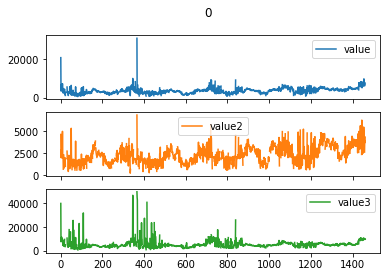

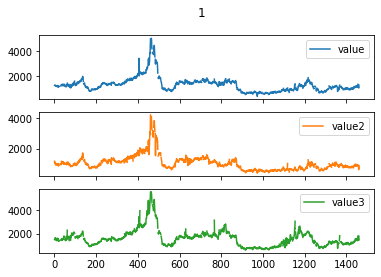

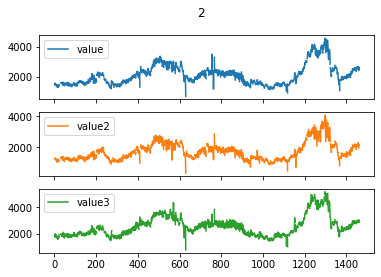

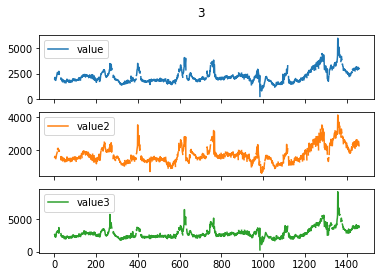

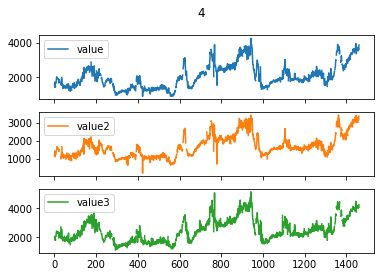

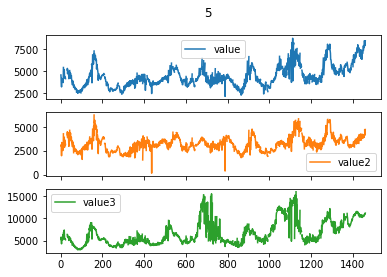

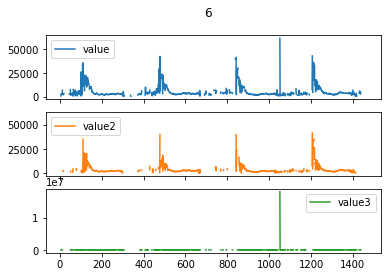

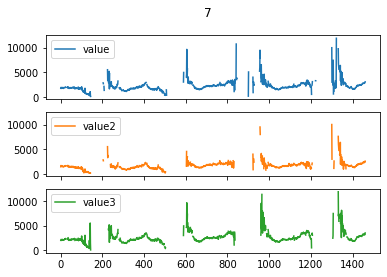

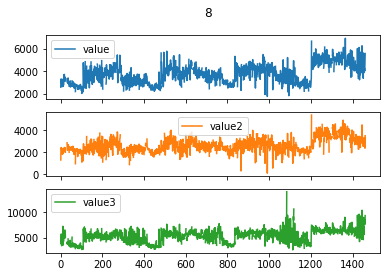

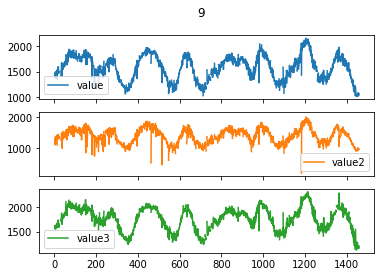

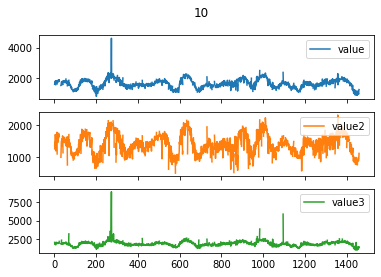

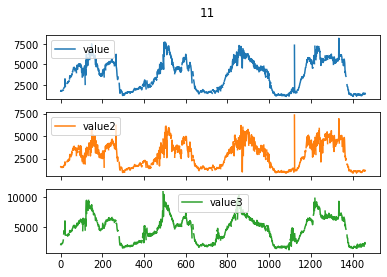

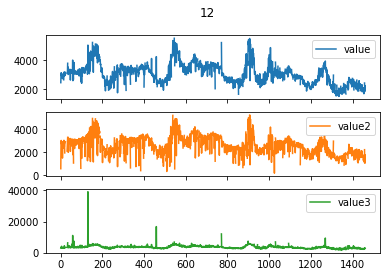

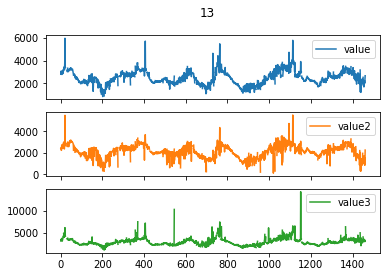

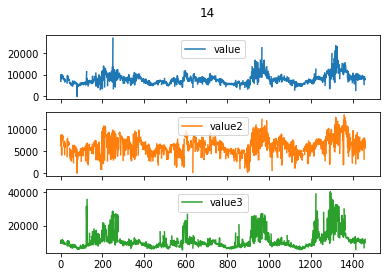

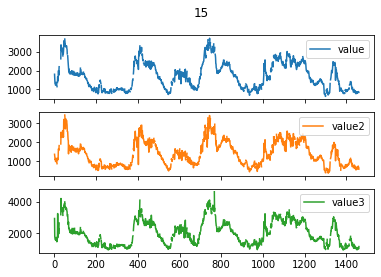

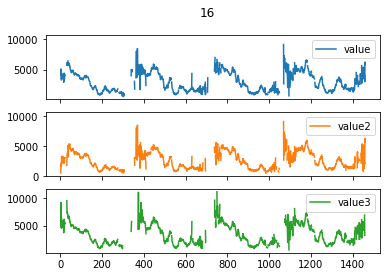

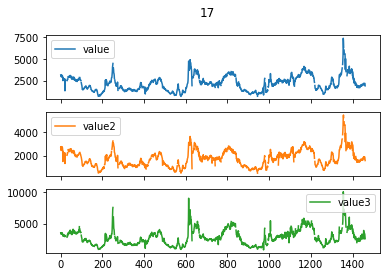

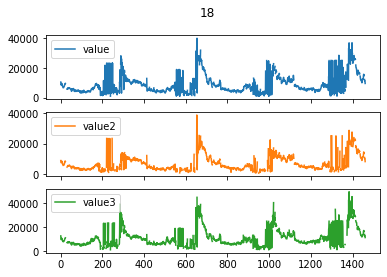

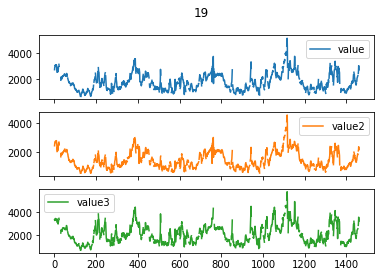

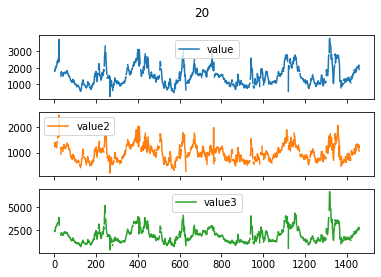

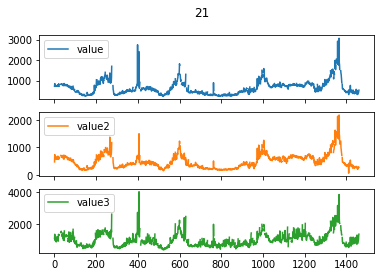

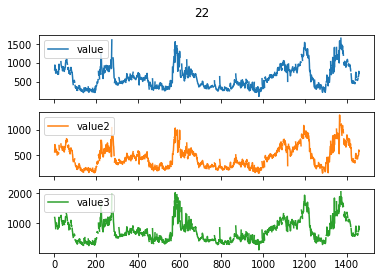

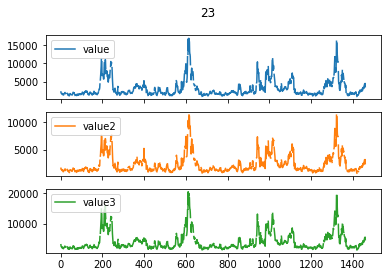

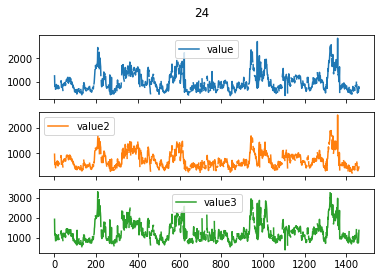

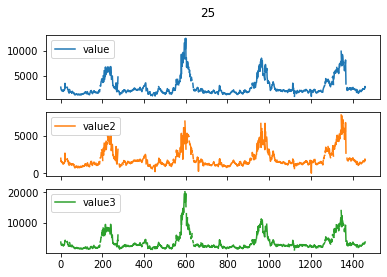

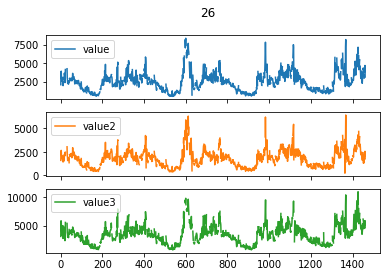

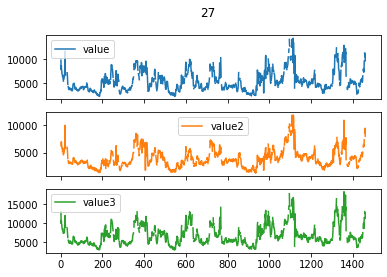

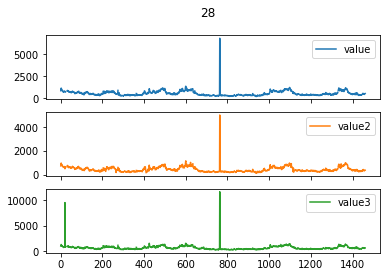

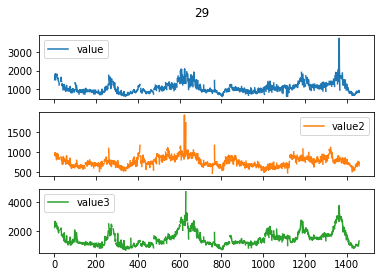

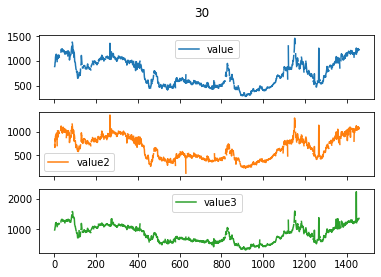

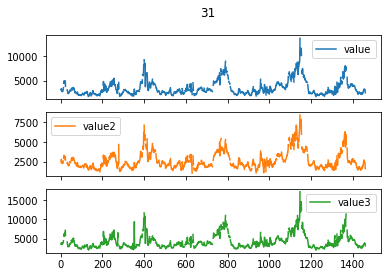

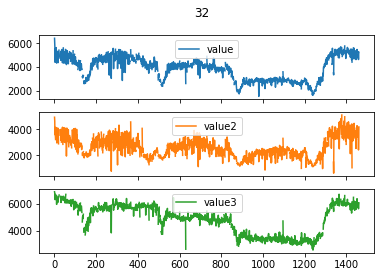

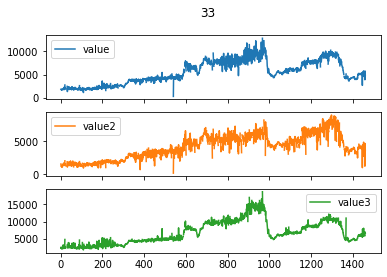

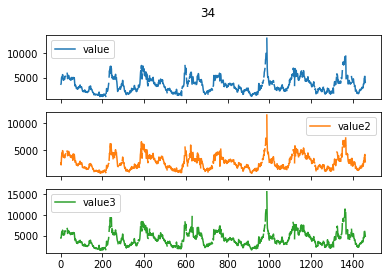

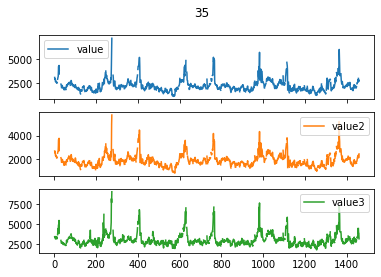

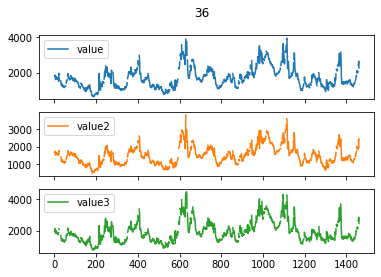

In [89]:
%cd /content/drive/MyDrive/data/train
for j in range(37):
  print(j)
  data = pd.read_csv(f"train_{j}.csv", encoding='utf-8')
  
  data["date"] = pd.to_datetime(data['datadate'].astype(str), format='%Y%m%d') #날짜변환
  data["value"] = data["해당일자_전체평균가격(원)"]

  data['value2'] = data["하위가격 평균가(원)"]
  data["value3"] = data["상위가격 평균가(원)"]
  data['value4'] = data['일자별_도매가격_평균(원)']
  data['value5'] = data['일자별_소매가격_평균(원)']

  #data["value"][1]=data["value"][2]
  #data["value"][366]=data["value"][367]
  #for i in range(1461):
  #  if(data['value3'][i]>20000):
  #    data['value3'][i]=np.nan
  data[['value','value2','value3']].plot(title=f'{j}',subplots=True)
  #train_0 은 value3이 이상치가 많음
%cd /content/drive/MyDrive/

## 37번 반복, 모델저장

0
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.023341: 100%|██████████| 100/100 [03:27<00:00,  2.08s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[5855.102, 7553.414999999999, 6185.186, 5843.2036, 7895.921399999999, 6745.2324, 8138.021999999999, 5638.2134, 7902.2207, 6473.2407, 5611.0776, 8228.52, 5072.0894, 6791.13, 6880.8423, 6975.0493, 6770.063, 6249.563, 7577.351999999999, 6076.4834, 8277.122, 9697.288, 7287.3115, 6574.21, 6127.7827, 6642.7603, 6571.2363, 7502.0815]
[5719.163048196888, 4498.691825753522, 4339.8804096490385, 4536.987869092298, 3895.586956252503, 4353.564582287145, 5338.692062637091, 4550.407680125022, 4342.01406099298, 4752.150436891032, 5185.544381229067, 4451.831245441937, 4078.74198624444, 4723.3599307334425, 4589.73779863832, 5508.490527470874, 6018.80949625082, 4876.049617704534, 4964.134105075145, 3161.7654978106675, 3181.6689207230415, 2598.249547506618, 2945.829295608592, 5163.235705918598, 5572.467061028004, 4316.411372425842, 4790.9615702131505, 3635.7776956422385]


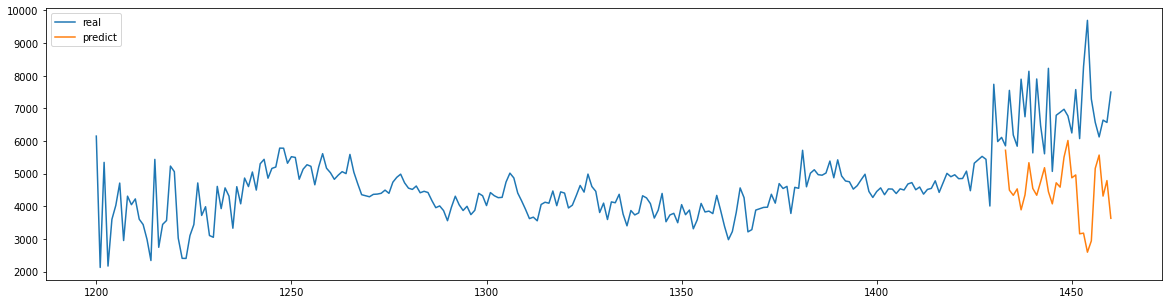

[-0.06451214 -0.26414555 -0.29012245 -0.25788143 -0.36279587 -0.28788412
 -0.12674607 -0.25568634 -0.28977345 -0.22268713 -0.15179655 -0.27181057
 -0.33283706 -0.22739641 -0.24925309 -0.098972   -0.01549874 -0.20242084
 -0.1880128  -0.48282761 -0.47957199 -0.57500234 -0.51814845 -0.1554456
 -0.08850731 -0.2939613  -0.21633876 -0.40529307]
0.26340460831448614
1
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.012006: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1003.9228, 1012.83777, 1085.1942, 1148.6968, 1115.1958, 1074.3827, 1064.2452, 1087.5468, 1102.4897, 1132.7411, 1183.132, 1097.6719, 1143.3948, 1142.552, 1181.991, 1209.9922, 1207.2228, 1200.7333, 1224.8239, 1115.7981, 1131.6555, 1164.931, 1338.5983, 1214.3657, 1164.2178, 1125.1622, 1048.06, 1282.6298]
[1017.777090229559, 977.9936386061074, 1101.8179919763327, 1122.6319169173526, 1145.5467708472402, 1102.7391689327972, 1107.766110958542, 1114.813420894219, 1086.1771884381594, 1089.6105110478104, 1118.6875771927998, 1142.178598761748, 1135.9797875618608, 1188.5116401152404, 1160.7587815459162, 1098.800780333108, 1038.9508979689003, 1081.2725260027648, 1162.1527740733998, 1203.8299784443893, 1200.597837638797, 1185.3205638037011, 1184.265179019715, 1261.3354424555064, 1258.04831654792, 1258.6778450736733, 1246.7833915804656, 1249.5853405557812]


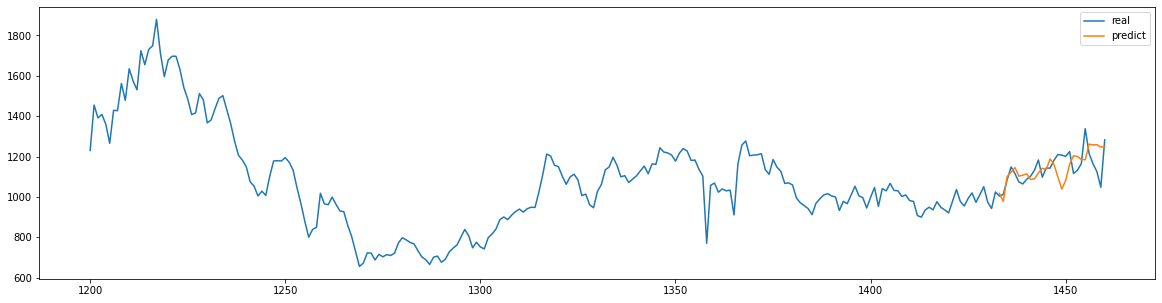

[-0.00673898 -0.04556413  0.07527756  0.09559012  0.11795301  0.07617655
  0.0810824   0.08795996  0.06001351  0.06336413  0.09174079  0.11466597
  0.10861647  0.15988295  0.13279859  0.07233303  0.0139248   0.05522699
  0.13415901  0.1748323   0.17167801  0.15676874  0.15573877  0.23095258
  0.22774463  0.228359    0.21675106  0.21948551]
0.12054926935174103
2
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.011347: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2486.7188, 2466.6406, 2459.535, 2488.451, 2464.468, 2484.995, 2473.3943, 2604.654, 2477.5786, 2509.3218, 2543.705, 2467.9966, 2424.595, 2400.5105, 2548.8325, 2389.953, 2512.8315, 2616.6074, 2528.575, 2642.4053, 2551.2036, 2608.6487, 2577.7534, 2594.569, 2664.242, 2478.7576, 2651.7305, 2426.8528]
[2390.4004201293947, 2000.734976154232, 2505.9003204719543, 2569.368847781372, 2261.339383943558, 2431.7224524692538, 2358.194437200928, 2447.60933079834, 2168.243671638584, 2333.3971757442473, 2379.5606890625, 2245.3757651924134, 2223.0783522745132, 1950.090495863247, 2303.006845816803, 2169.322577534199, 2256.8085747501373, 2707.2975521652224, 1972.7782072969915, 2365.5019120853426, 2096.7886912305357, 2386.510432513809, 1865.785162142277, 2254.7176911514284, 2229.496990495682, 1995.7463239370347, 2296.231281644058, 2102.1307118558884]


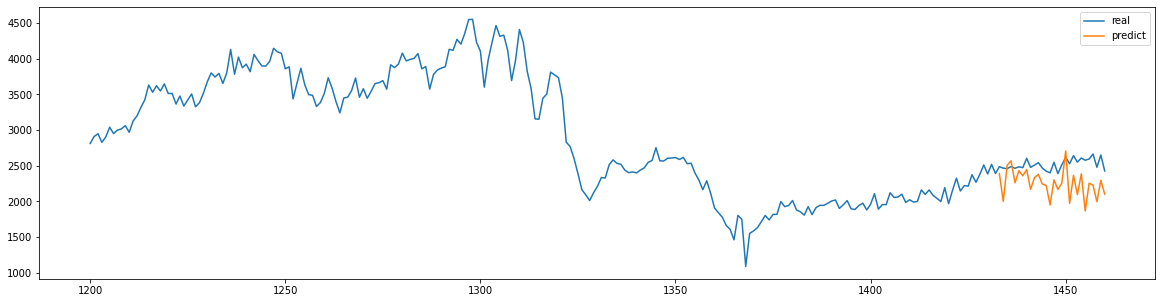

[-0.00051303 -0.16344202  0.0477804   0.0743182  -0.05447672  0.01676476
 -0.01397917  0.02340746 -0.0934024  -0.02434753 -0.0050454  -0.06115151
 -0.07047463 -0.18461776 -0.0370545  -0.09295128 -0.05637117  0.13198969
 -0.17513146 -0.01092373 -0.12327953 -0.00213953 -0.21986796 -0.05724542
 -0.06779083 -0.16552791 -0.03988753 -0.1210459 ]
0.07624740814602307
3
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.021334: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2907.8337, 2842.3733, 2906.746, 3025.724, 2955.739, 2875.9653, 2878.8289, 2828.4727, 2782.6848, 2881.5845, 3038.5237, 2953.0854, 2970.1614, 3145.442, 3191.6865, 2986.3113, 3050.5454, 3138.1345, 2968.356, 2873.6997, 2961.6875, 2920.6338, 3088.8997, 3055.026, 3109.1643, 3022.4517, 2972.49, 2994.195]
[3164.326929908716, 3186.7998145135875, 3038.239641819858, 2832.327967788541, 2556.2927248178958, 2509.855475928539, 2453.6503379619357, 2240.6737489529114, 2198.704384331518, 2163.09220235669, 2205.6414660334226, 2157.3278657082556, 2039.077479467127, 2104.7635345769, 2085.155028952952, 2222.849070871019, 2317.8179246512886, 2386.680823145443, 2252.3309872209365, 2315.0082754666, 2439.5602837789593, 2533.629599420988, 2454.56524170261, 2300.979704018229, 2308.111294735068, 2381.4455022379398, 2533.0219264295038, 2790.1242675675985]


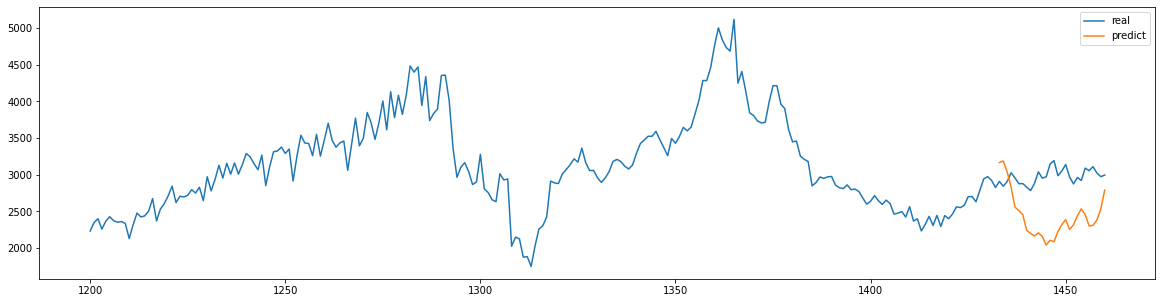

[ 0.12017731  0.12813275  0.07554219  0.00264909 -0.09506787 -0.11150674
 -0.13140346 -0.20679755 -0.22165477 -0.23426155 -0.21919904 -0.23630214
 -0.27816298 -0.25491    -0.26185145 -0.21310751 -0.17948837 -0.15511078
 -0.20267086 -0.18048299 -0.13639136 -0.10309066 -0.13107958 -0.18544913
 -0.18292454 -0.1569641  -0.10330578 -0.01229109]
0.16142770108611604
4
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.012323: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[3576.874, 3479.0444, 3546.313, 3622.7356, 3582.27, 3553.958, 3517.4531, 3646.3855, 3421.1484, 3573.717, 3668.0688, 3640.1836, 3939.5420000000004, 3626.1821, 3770.2642, 3365.4358, 3606.0815, 3733.7153, 3690.0442, 3664.6357, 3622.8896, 3655.6978, 3534.484, 3659.034, 3665.9036, 3651.9495, 3577.629, 3852.1523000000007]
[2841.458407311261, 2780.233628202343, 2771.938838410175, 2739.20955825184, 2803.7638736848357, 2844.3964506397247, 3075.210225001955, 3028.4300777808194, 3059.6949935251237, 3149.033093089414, 3186.382649426508, 3301.2414577729105, 3181.3884869297267, 2908.263026527691, 2868.985255015624, 2796.5380932011603, 3034.3003712728623, 3141.2618463747976, 3154.499000954187, 3375.0385405970574, 3301.933911363876, 3314.6751255925183, 3218.6597787451387, 3300.7315456715587, 3198.0078274787666, 2998.148636969352, 2806.0601252172114, 2853.6686382211747]


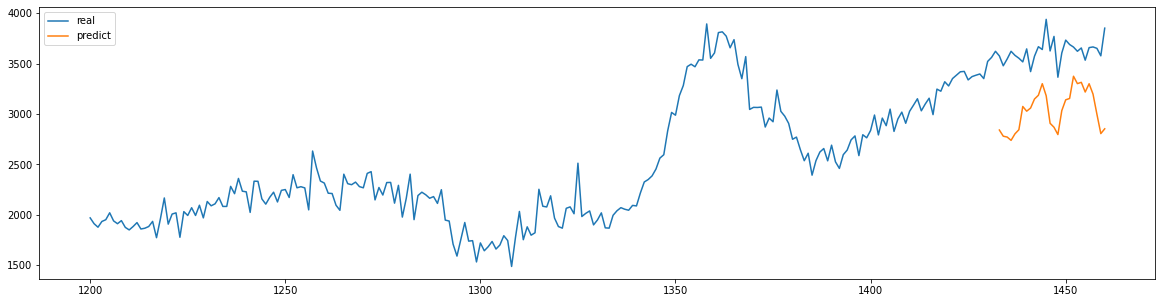

[-0.21565565 -0.23255588 -0.23484554 -0.24387999 -0.22606069 -0.21484464
 -0.15113177 -0.16404476 -0.15541453 -0.13075401 -0.12044419 -0.08873905
 -0.12182276 -0.19721518 -0.20805725 -0.22805526 -0.16242435 -0.13289915
 -0.12924522 -0.06836841 -0.0885479  -0.08503087 -0.11153455 -0.0888798
 -0.11723523 -0.17240353 -0.22542684 -0.21228519]
0.16170722149157446
5
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.019839: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[6697.6704, 7361.316000000001, 6804.2437, 7021.8247, 6695.1694, 7422.1387, 6672.428, 6418.006, 7299.0903, 6788.006, 7325.822, 6343.6377, 7088.310000000001, 7231.787, 6977.0825, 7294.777, 7292.798, 7797.0693, 7335.752, 7865.280999999999, 7889.432, 7648.614, 8367.677, 8031.2827, 8427.141, 7873.4966, 8132.9976, 8427.007]
[5473.850251819086, 6169.087276085091, 6224.954764623546, 6174.80262461729, 6022.388936227131, 6145.733616125202, 5485.91553469851, 5673.535856774616, 5851.952559706783, 6068.726796590805, 5983.227264011382, 5857.797999631977, 5265.700380469799, 5039.458352186465, 5282.414262458873, 5544.4599571944, 5305.4267360587355, 5858.285061807346, 5794.476100819778, 5546.269962108921, 5494.890626628756, 5130.775832043361, 4607.036946883523, 4849.9334487531305, 4886.523300856984, 4742.783109184313, 4551.075792542112, 4691.002875394737]


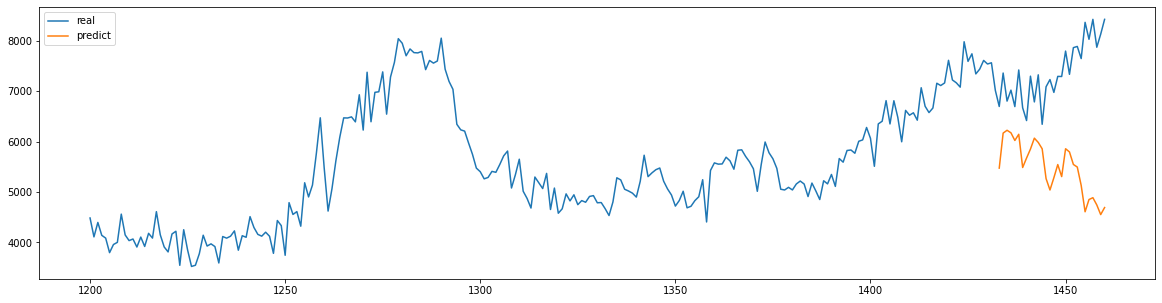

[-0.21992771 -0.12085026 -0.11288865 -0.12003577 -0.14175608 -0.12417836
 -0.2182083  -0.19147074 -0.16604477 -0.13515252 -0.14733696 -0.16521175
 -0.24959092 -0.28183242 -0.24720904 -0.2098652  -0.24392956 -0.16514234
 -0.17423568 -0.20960726 -0.21692927 -0.26881886 -0.34345631 -0.3088414
 -0.30362702 -0.32411127 -0.35143127 -0.33149042]
0.2176135744790013
6
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.478931: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[3976.4958, 3970.433, 3949.767, 5041.676, 2998.0288, 3768.743, 3813.5151, 2603.8247, 3979.2134, 3968.7446, 5730.7007, 4222.36, 4261.351, 5782.213, 4453.8047, 4483.6865, 4473.9805, 5785.4224, 4409.478, 5850.676, 4488.7915, 4790.765, 1010.7171600000001, 5054.771, 5666.9014, 4950.431, 13609.351, 5737.2046]
[2882.9654299968274, 3266.4703416763427, 3218.792288473271, 2941.106006285903, 2799.894373203874, 3008.8541512403744, 3438.2512879425885, 3177.6863004716683, 3172.976995359743, 3274.731274162921, 5012.29912674911, 5554.769570807672, 6720.56247730782, 5890.658313115191, 5090.078925762379, 5761.871019480073, 6154.570254198456, 7691.168032942653, 9190.142128058362, 6884.65116913793, 3307.6269464727193, 3725.8248715049535, 3583.8854054368317, 3510.029953212093, 3554.116642983651, 3359.3160353342787, 3658.453496244422, 3467.0281297847687]


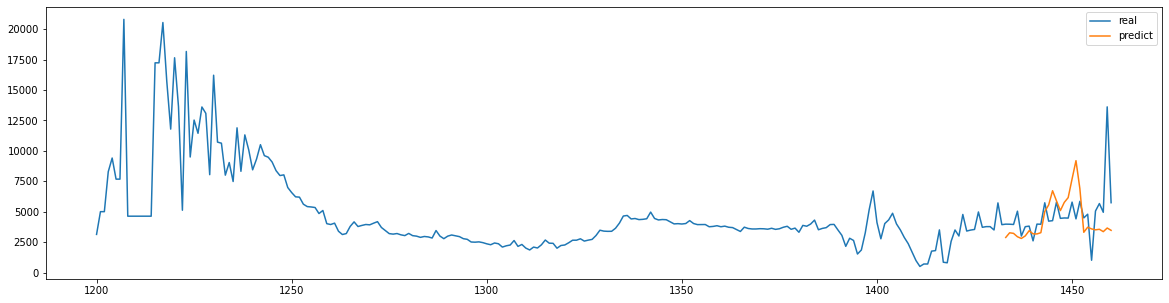

[-0.26702925 -0.16952621 -0.18164797 -0.25224747 -0.28814939 -0.23502305
 -0.12585229 -0.19209884 -0.19329614 -0.16742593  0.27433671  0.41225545
  0.70864891  0.49765246  0.2941116   0.46490933  0.56474995  0.95541756
  1.33651966  0.75036714 -0.15906247 -0.05273902 -0.08882598 -0.10760314
 -0.09639445 -0.14592094 -0.06986765 -0.11853601]
0.3275076770515558
7
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.035351: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2366.3638, 2396.7385, 2429.6025, 2476.7808, 2437.3545, 2417.0964, 2406.0857, 2432.6702, 2434.8364, 2492.9785, 2510.7722, 2583.218, 2640.5583, 2676.3445, 2625.4153, 2670.0146, 2737.6455, 2801.3704, 2802.1409, 2808.7214, 2811.1096, 2755.1692, 2763.104, 2802.862, 2836.0852, 2843.0015, 2865.9844, 3069.7458]
[2483.754301084298, 2448.993305910805, 2319.580853265086, 2378.179869459036, 2545.0749533653916, 2466.273171952802, 2161.8053592011956, 2380.738429719922, 2071.9960548822073, 2059.0021675965277, 2181.4085278485422, 2301.4585922719625, 2219.6258586211598, 2452.6633158005743, 2488.5186219739257, 2335.5665484600067, 2199.0008945841646, 2366.2306211212067, 2665.0443756347117, 2634.745895270723, 2667.5535908126653, 2660.9099061736165, 2789.2721613972067, 2943.337373880231, 2602.9060826862274, 2584.314348595959, 2396.0742875015885, 2121.6050427297414]


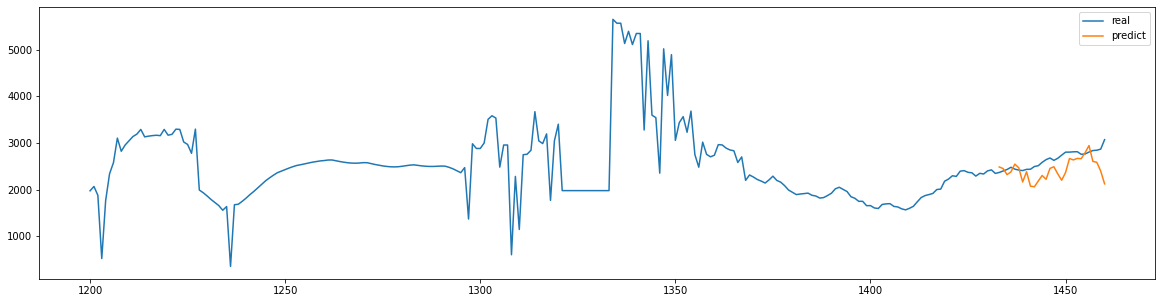

[ 0.05899786  0.04417682 -0.01100074  0.01398411  0.08514313  0.05154443
 -0.07827145  0.015075   -0.11656343 -0.12210363 -0.06991325 -0.01872753
 -0.05361854  0.0457416   0.06102922 -0.00418493 -0.0624124   0.00888931
  0.13629447  0.12337612  0.13736433  0.13453166  0.18926145  0.25495021
  0.10980058  0.10187363  0.02161375 -0.09541165]
0.07949482914040287
8
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.016544: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[3241.6018, 4537.945, 4187.9297, 3700.2625, 3692.4368, 5676.0947, 4882.9824, 4189.314, 4240.3916, 4230.3867, 3885.3179, 4091.969, 6239.9316, 5163.325, 3954.5947, 3905.2454, 4219.292, 3978.8335, 3371.5586, 5605.921, 4391.013, 3872.0054, 4475.058, 4183.931, 4234.1875, 4016.3137, 4812.168, 5555.332]
[3264.6462166956426, 3918.1232470960617, 3228.615585346365, 3382.029662480879, 4352.135429846191, 3975.170802186632, 3913.662297509146, 4086.3130063005924, 3993.5182932856083, 3431.434093232894, 3623.751278186762, 4162.765675640869, 4509.644350621128, 4021.8558368711947, 3327.8824723364355, 3611.2614548093798, 3641.742110320562, 4348.129361321926, 3588.4811951040388, 4272.6008233905795, 3982.248094848871, 3848.4197077898143, 3391.0213971044063, 3361.344402281046, 3543.7895328922987, 4160.617815087509, 4556.298452954674, 3399.734959947157]


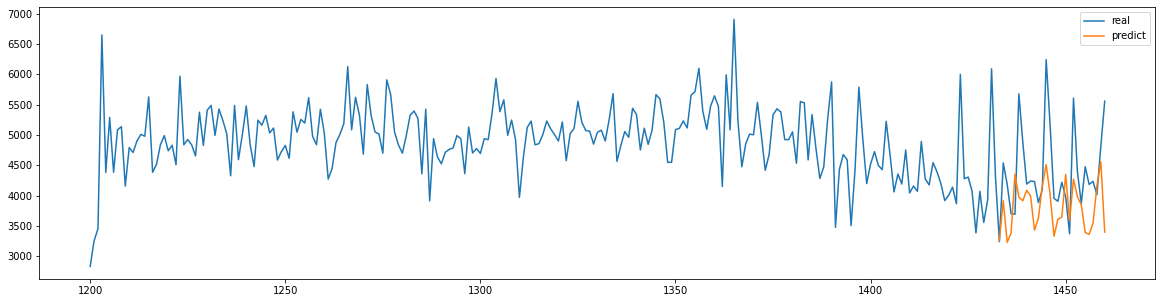

[-0.24318144 -0.09169074 -0.25153415 -0.21596931  0.00892306 -0.07846583
 -0.09272489 -0.05270056 -0.07421247 -0.20451625 -0.1599328  -0.03497711
  0.04543718 -0.06764319 -0.22852185 -0.16282822 -0.15576211  0.00799437
 -0.1681092  -0.00951485 -0.07682515 -0.10784959 -0.21388483 -0.22076462
 -0.17846973 -0.03547503  0.05625265 -0.21186483]
0.12342950072231083
9
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.011907: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1257.6124, 1132.781, 1200.4596, 1193.8456, 1179.2639, 1098.6552, 1125.5889, 1229.568, 1039.2327, 1120.1833, 1189.0916, 1162.225, 1033.2706, 1026.8712, 1028.4216, 1021.0557, 1049.6573, 1025.4742, 1024.925, 1067.8492, 1018.7997, 1052.9861, 1086.7188, 1101.9313, 1045.6421, 1034.7692, 1046.1354, 1070.9822]
[1309.9370944378256, 1286.6923973297835, 1339.6257262299418, 1324.9538435769082, 1343.2823658471823, 1277.736548654771, 1286.713494632268, 1408.072072351277, 1382.4684385804774, 1355.9084010587694, 1332.3786496303321, 1344.655922795868, 1364.8353394261242, 1278.2161621235969, 1279.3411910982013, 1259.7023381311894, 1298.4757878965975, 1338.8349932049753, 1382.1363311476946, 1347.70599308151, 1304.237124173522, 1278.8555154376866, 1307.2757922863484, 1371.8832828770758, 1360.4206632257342, 1373.713867800641, 1403.7034644306898, 1331.944863704455]


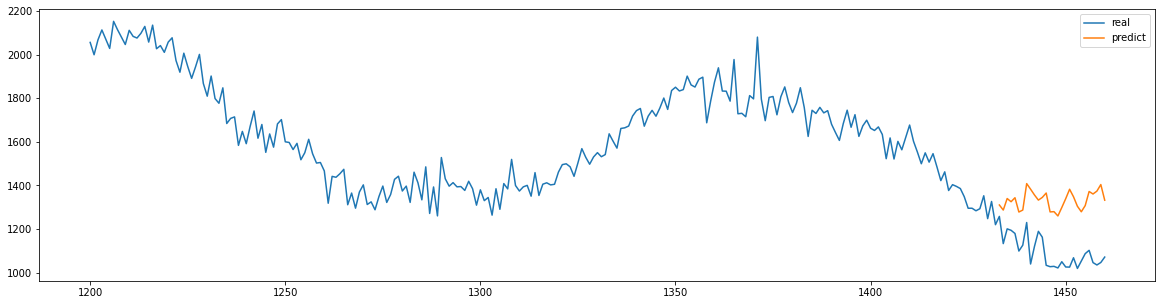

[0.07405655 0.05499753 0.09839915 0.08636923 0.10139734 0.04765436
 0.05501483 0.15452035 0.13352717 0.1117498  0.09245705 0.10252356
 0.11906926 0.04804761 0.04897006 0.03286758 0.06465909 0.0977508
 0.13325486 0.1050244  0.06938298 0.04857184 0.07187447 0.12484808
 0.11544954 0.12634903 0.1509384  0.09210138]
0.0914937975869418
10
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.018191: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1269.2975, 1063.0985, 1188.2666, 1146.0261, 1051.1617, 975.0618, 1251.4994, 1093.4808, 930.1750000000001, 1059.2524, 956.9988, 1078.7125, 924.2966, 1178.6152, 1078.8627, 948.7256499999999, 1010.8288, 908.4895, 972.5812, 891.69696, 1097.1592, 992.1327, 1167.3987, 1124.2258, 1029.4965, 966.359, 1214.1305, 1263.5574]
[1229.3336835802793, 1256.1307661803962, 1249.0387356016158, 1283.993841902566, 1211.8667790025474, 1274.4403886635066, 1362.12562483083, 1288.1932333324671, 1233.8793463127852, 1226.7883704497815, 1247.7953473991633, 1323.4894793381095, 1209.9956726491453, 1199.1686906760217, 1204.6848136208296, 1358.2838428981304, 1387.631390509653, 1319.4909909806252, 1274.97184371686, 1340.3756411829352, 1348.2820543220996, 1412.0709196704745, 1372.4135253442169, 1351.225664639175, 1423.192694703114, 1405.0972809376, 1422.2849900795102, 1464.643562216729]


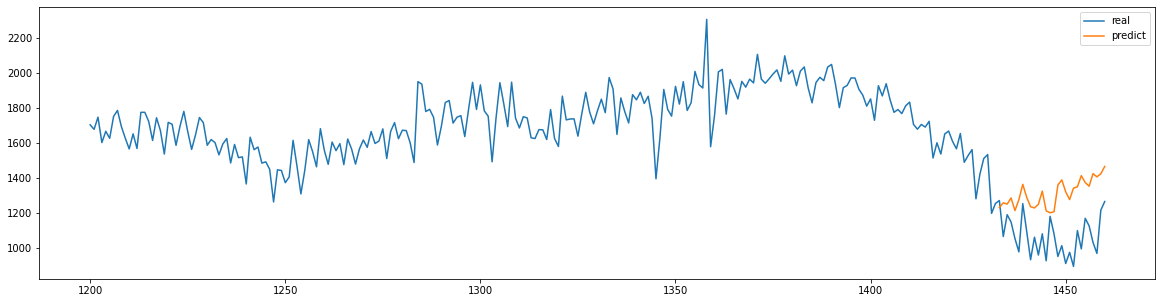

[-0.01865684  0.00273453 -0.00292684  0.02497686 -0.03260018  0.0173506
  0.08734731  0.02832912 -0.01502816 -0.02068869 -0.0039194   0.05650514
 -0.03409384 -0.04273672 -0.03833335  0.08428052  0.10770786  0.05331325
  0.01777485  0.06998489  0.07629637  0.12721726  0.09555985  0.07864617
  0.13609546  0.12165039  0.13537087  0.16918455]
0.06068963780364595
11
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.006094: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1329.8773999999999, 1260.7077999999997, 1330.9762999999998, 1346.7314000000001, 1273.5955, 1284.3267, 1240.1889999999999, 1252.0125000000003, 1185.9766, 1259.7090000000003, 1300.1754999999998, 1209.0023999999999, 1215.5342, 1297.8083000000001, 1318.0553999999997, 1382.9577999999997, 1431.8428, 1482.2036000000003, 1451.6610999999998, 1464.1604000000002, 1473.7096999999999, 1411.4416999999999, 1351.2444, 1343.8853, 1413.6621, 1367.6814, 1494.1781999999998, 1432.7954]
[2541.4973602698565, 3061.466084146519, 2926.996028400332, 3077.8821764097647, 3276.7987576944843, 3215.0720571883276, 2836.359827775851, 3240.2187037108433, 3200.572966310686, 3087.3130098022657, 3136.795426500158, 3010.011622288358, 3324.2691205625606, 3315.0029088294727, 3472.776409143789, 3264.7338758184596, 3238.058796186304, 4024.1962794339047, 3483.0477303955404, 3594.6462058556535, 3657.312931713579, 3959.779384519905, 4257.047679081205, 4431.4093599

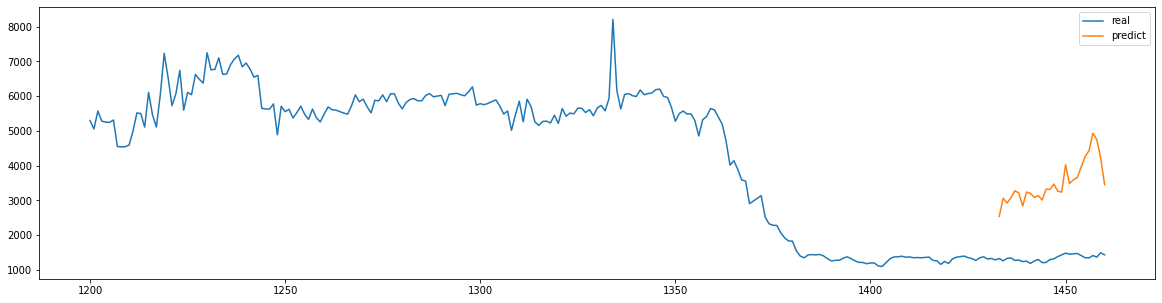

[0.97598014 1.38024886 1.27570019 1.39301215 1.54766713 1.49967544
 1.20523176 1.51922662 1.48840259 1.4003445  1.43881641 1.3402437
 1.5845747  1.57737034 1.70003712 1.53828684 1.51754733 2.12875868
 1.70802294 1.79478926 1.8435118  2.07867541 2.30979753 2.4453614
 2.83656935 2.69273478 2.27651706 1.68477202]
1.7207812879467765
12
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.018203: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2311.4297, 2182.1282, 2245.8704, 1901.8284, 2375.41, 2238.7493, 2170.259, 1958.8926, 2301.0334, 2164.44, 2091.0022, 2251.9614, 2313.529, 1820.5443, 2047.4204, 2036.4652, 2092.39, 1898.4769, 2093.8691, 2066.486, 2079.7874, 1686.9576, 2001.2405, 2207.85, 2429.0093, 1838.4171, 2250.3457, 2150.2646]
[2754.074991727695, 2708.7600299269466, 2655.5923499851433, 2664.8391781769724, 2523.955265769905, 2256.9799702185746, 2473.083584275454, 2754.856438102013, 2738.0698771603106, 2883.7408584636555, 2810.3997048507063, 2942.283959375997, 2951.378758827083, 2813.7616844146223, 2876.8641501466723, 3077.4879730694684, 2941.438718001382, 2747.3844840083448, 2930.545947723728, 2891.403915029426, 3283.9402589373426, 3180.3758283934667, 3122.668281649927, 2938.129232286249, 3209.525142769574, 3070.6684909584646, 3153.5950799838724, 3475.958336209214]


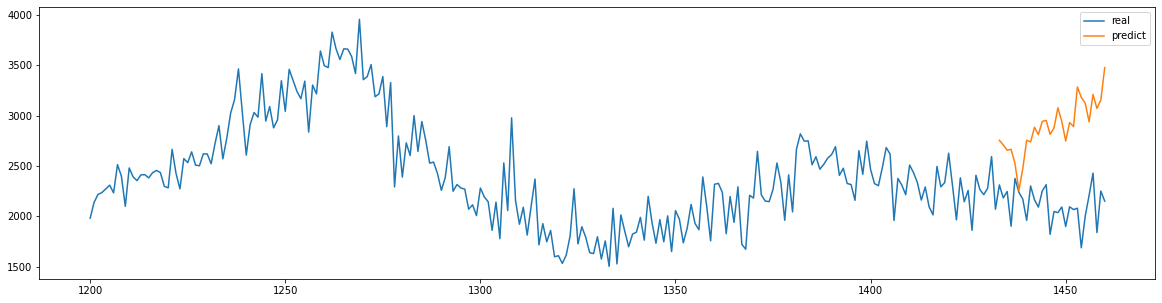

[0.33025669 0.30836893 0.2826882  0.28715455 0.21910565 0.09015285
 0.19453392 0.33063414 0.322526   0.39288712 0.35746231 0.42116425
 0.42555717 0.3590862  0.38956557 0.48646968 0.42075599 0.32702508
 0.41549463 0.39658848 0.58618902 0.53616595 0.5082924  0.41915746
 0.55024548 0.48317577 0.52323047 0.67893643]
0.3943882279704867
13
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.018824: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1994.8993, 2786.6487, 2207.4558, 3170.26, 1253.4596, 1975.4971, 1222.3776, 1324.557, 2167.3604, 2002.7861, 2164.359, 2160.2854, 2301.5522, 2398.309, 1997.051, 2328.462, 2181.8682, 2534.2744, 1935.1589, 1817.9563, 2214.1157, 1699.1946, 2052.61, 2101.491, 2227.9663, 2020.5881, 2395.3762, 2673.493]
[2633.2377415988876, 2656.6287345823735, 2539.9007803291543, 2647.959920226294, 2321.1901377122504, 2373.298589183367, 2270.5256297506526, 2327.0704742380813, 2189.0437060399413, 2245.6665137857854, 2201.382851986706, 2377.552015949028, 2500.4197578317026, 2267.0013766862617, 2387.243995488576, 2723.9430808386237, 2781.9364006008236, 2602.562349321142, 2609.6599747164487, 2804.702106528309, 2538.5238538434724, 2168.5067355394062, 2708.246639059189, 2970.20408041271, 2784.4758063370823, 2568.9921064330115, 2955.748485440898, 2629.392704725103]


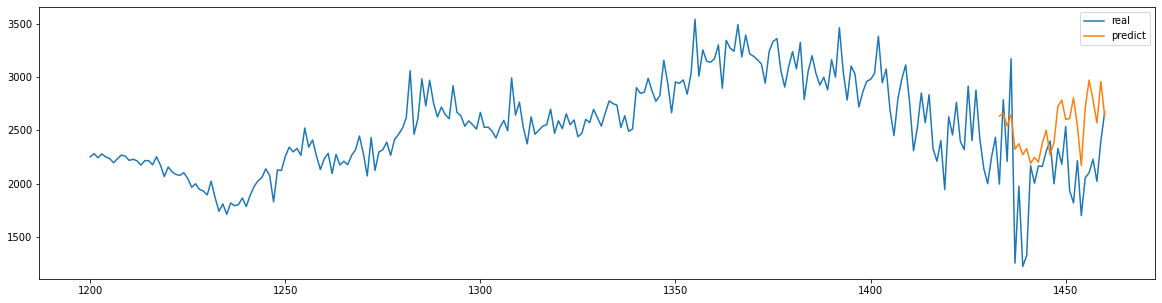

[ 0.08198577  0.09159702  0.04363402  0.08803505 -0.04623322 -0.02482208
 -0.06705104 -0.04381701 -0.1005316  -0.07726554 -0.0954615  -0.02307437
  0.02741144 -0.06849914 -0.01909198  0.11925619  0.14308539  0.06938138
  0.07229777  0.15243972  0.04306825 -0.10897015  0.11280659  0.22044375
  0.14412882  0.05558752  0.21450401  0.08040586]
0.08696022057698607
14
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.034530: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[9406.326, 9733.168, 8679.777, 8225.34, 8800.564, 8487.673, 8583.614, 9291.283, 7947.72, 8448.584, 8372.598, 8479.087, 8239.422, 8330.261, 9662.181, 8209.716, 8586.093, 9122.587, 8756.069, 8631.127, 8972.7, 8871.581, 5500.4873, 8097.993, 8995.492, 7614.7515, 7689.331, 8174.6304]
[8901.747047855926, 8346.815599117208, 7604.580814959103, 7050.146589535463, 7195.750954131878, 7625.358582182967, 7171.40094898448, 8933.481842692732, 8471.256243648457, 7059.12706617614, 7591.932779954898, 7947.945660933805, 9641.725168067504, 9440.106715303325, 9294.860694799256, 7022.546575123239, 8081.368035322672, 8640.111807969643, 7435.831014552415, 7569.077710712034, 7846.120930079338, 7933.019923128986, 6873.689315065408, 7789.320106495184, 8216.768593663453, 7686.441021443195, 7130.964917027027, 5580.335102266669]


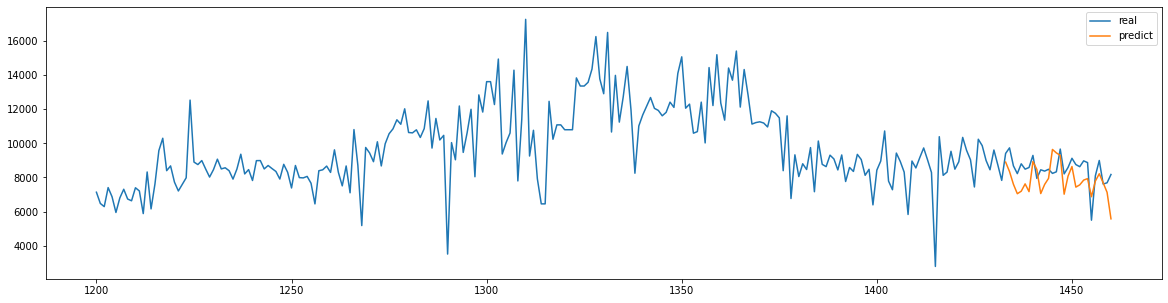

[ 0.13692784  0.0660522  -0.02874575 -0.09955789 -0.08096135 -0.02609202
 -0.08407133  0.14098099  0.08194571 -0.0984109  -0.03036116  0.01510868
  0.23143757  0.20568694  0.18713617 -0.10308295  0.03214933  0.10351188
 -0.05029842 -0.0332802   0.00210366  0.01320237 -0.12209494 -0.00515092
  0.04944264 -0.0182906  -0.0892358  -0.28728167]
0.08652149550551069
15
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.005397: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[908.3911, 863.6542, 944.5405, 995.2341, 951.9866300000001, 907.16693, 943.54663, 872.3448, 892.2413, 901.7986, 907.4213999999998, 794.8218, 864.3049, 771.38055, 811.8387000000001, 853.4802, 859.3678, 863.49524, 793.743, 847.6484, 842.18634, 807.6355, 844.70074, 865.8846, 877.5662, 858.4373, 851.64386, 851.4157999999999]
[1101.7618832503317, 1131.034692737913, 1222.2845677767755, 1274.419910005188, 1225.391795799589, 1191.0624589954377, 1070.2133196686268, 1088.6875157152176, 1064.6279571925163, 1059.998888501978, 1061.2701576863287, 1020.2427018676757, 996.618354294157, 932.8346620117187, 960.162271991825, 1022.1050484214783, 1052.64826986537, 1061.4221479450225, 1127.4549457107544, 1123.0689570759296, 1088.327927187538, 1097.5797285352705, 1153.4372667287348, 1144.3246717606544, 1067.4408578310968, 1129.3393192981243, 1163.2583047662733, 1200.5541723822116]


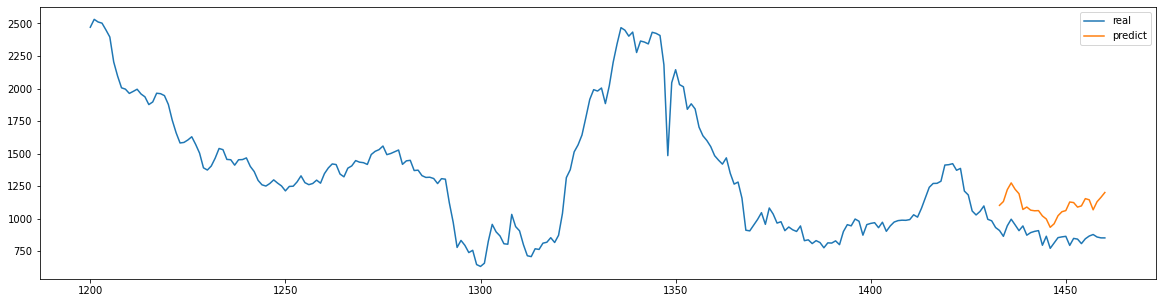

[0.18316243 0.21459798 0.31258959 0.3685768  0.31592639 0.27906072
 0.14928299 0.1691221  0.14328497 0.13831389 0.13967909 0.09562043
 0.07025067 0.0017545  0.03110113 0.09762038 0.1304202  0.13984231
 0.21075375 0.20604372 0.16873594 0.17867129 0.2386557  0.22886985
 0.14630569 0.21277735 0.24920234 0.28925371]
0.18248128182374934
16
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.011018: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2781.9111, 2599.9187, 3232.26, 3205.0278, 4321.109, 3811.3389, 3992.446, 4257.7397, 2706.9521, 3897.5784, 5660.559, 2775.708, 5171.8696, 5345.028, 4104.171, 4929.871, 4715.696, 4257.0044, 4995.8945, 5402.136700000001, 3956.3713, 3445.2605, 4102.3325, 3883.87, 4105.2764, 2997.5698, 6238.6, 5857.504]
[2857.385787584971, 2992.7754927017822, 2784.916347380155, 2901.904564059096, 2859.4347859259587, 2718.3903356771566, 2465.292746652382, 2369.159646062128, 2255.357705462275, 2322.0646193772745, 2547.19942821505, 2549.827563002173, 3148.013501746453, 2963.6040532635375, 3295.1602116538043, 3215.0527182739925, 3109.3015746653896, 2912.7832313462895, 2960.7872034125025, 2905.4885816699457, 2303.457563443315, 1799.2389866514118, 2089.730031207785, 1994.8741257743404, 1758.7067555715173, 2351.5169192782846, 2407.933191105236, 2500.7009736072364]


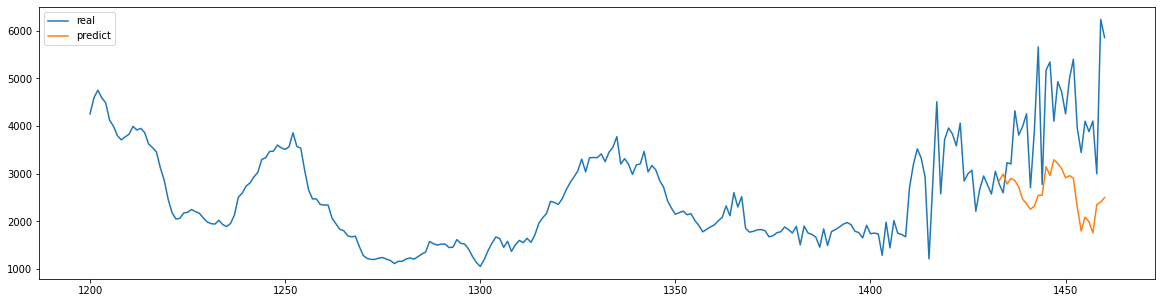

[-0.06352716 -0.01915486 -0.08727812 -0.04893668 -0.06285562 -0.1090812
 -0.1920308  -0.22353724 -0.26083441 -0.23897205 -0.1651869  -0.16432556
  0.03172248 -0.02871544  0.07994799  0.05369375  0.01903512 -0.04537133
 -0.02963862 -0.04776206 -0.24507028 -0.41032168 -0.31511684 -0.34620468
 -0.42360562 -0.22931942 -0.21082969 -0.18042619]
0.15473220745549163
17
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.008969: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1814.1877, 1729.5667, 1792.1182, 1898.2555, 1829.2767, 1944.3658, 1974.9187, 2041.0007, 1897.0151, 1957.2919, 2014.8304, 1952.7167, 2093.8618, 1989.7566, 2020.5718, 1978.3384, 2041.1821, 2128.9697, 2111.685, 2125.4973, 2216.5627, 2117.7234, 2058.4639, 2120.7578, 2173.128, 2214.723, 2124.7432, 1919.9404]
[1798.8769078077971, 1811.186858397764, 1841.2661549351155, 1869.198102309501, 1843.2447954236268, 1914.1519887358725, 1812.668408246076, 1719.0694645212827, 1686.1088204341827, 1586.6347814433216, 1512.9998782366633, 1494.4447430861949, 1627.4491974265336, 1704.525425089967, 1648.0930601739942, 1575.033566308808, 1518.5110282688497, 1539.1325194075941, 1530.035623354125, 1569.283882161069, 1663.5354335410952, 1699.805919189155, 1628.964575749415, 1618.3771306060016, 1605.2277567784845, 1651.3459788210153, 1658.4157685906766, 1659.4917743010162]


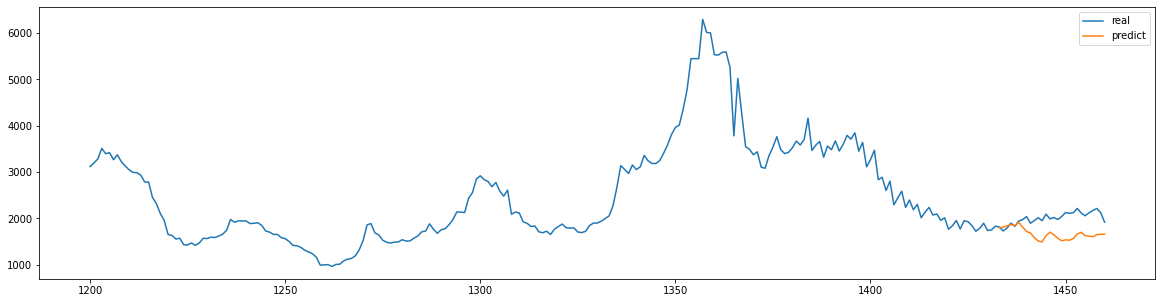

[-0.01854985 -0.01183366  0.00457732  0.01981672  0.00565684  0.04434313
 -0.01102534 -0.06209204 -0.08007505 -0.13434714 -0.17452164 -0.18464515
 -0.11207918 -0.07002713 -0.10081609 -0.14067665 -0.17151481 -0.16026392
 -0.1652271  -0.14381363 -0.09239088 -0.07260204 -0.11125241 -0.11702882
 -0.12420299 -0.09904133 -0.09518412 -0.09459706]
0.09365007367737922
18
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.037012: 100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[16749.299, 16140.5205, 14503.507, 14542.424, 13018.372, 12263.9795, 12497.945, 12183.427, 11691.075, 11326.336, 11172.062, 10130.28, 10174.905, 10924.915, 11538.164, 12492.291, 12018.279, 12588.8, 13006.695, 15152.216, 15792.504, 14665.411, 15029.689, 12602.431, 12289.31, 11400.438, 11444.085, 9636.488]
[17336.724702957035, 18810.595883724367, 11659.40532618729, 14359.647288390208, 13124.358590627504, 24116.979610693365, 22100.284270179036, 16592.83652438872, 17018.89844329308, 14275.486240399123, 8882.23542344468, 9022.095443857936, 11040.185478754813, 11785.360922798027, 11451.406404500616, 5569.432042454325, 12188.919589886904, 10277.559516248035, 9461.696227252083, 8762.127835129213, 17290.80985122422, 13079.176738937105, 12821.643495595652, 12915.672575471915, 15077.346895627941, 11719.357806042444, 9177.117050877461, 7248.096868927172]


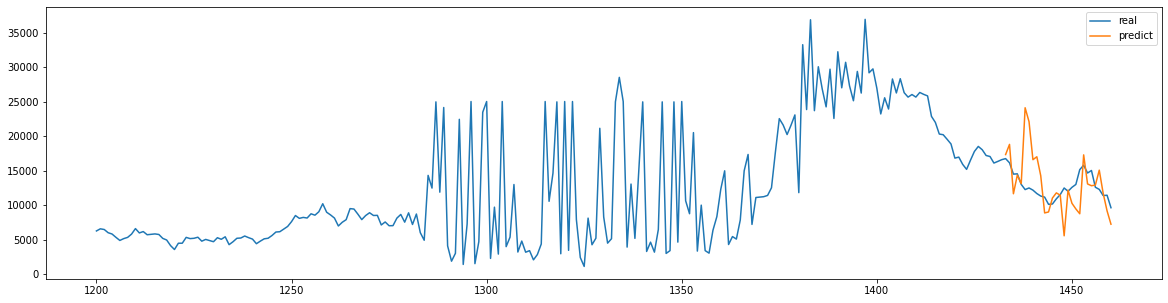

[ 4.45723643e-02  1.33376053e-01 -2.97497492e-01 -1.34802509e-01
 -2.09231125e-01  4.53096294e-01  3.31586363e-01 -2.48387407e-04
  2.54226960e-02 -1.39873380e-01 -4.64827537e-01 -4.56400691e-01
 -3.34806727e-01 -2.89908415e-01 -3.10029843e-01 -6.64430572e-01
 -2.65593198e-01 -3.80756468e-01 -4.29913864e-01 -4.72064260e-01
  4.18059026e-02 -2.11953422e-01 -2.27470316e-01 -2.21804875e-01
 -9.15596709e-02 -2.93885235e-01 -4.47060329e-01 -5.63287656e-01]
0.28347377302301485
19
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.008806: 100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2161.4648, 2308.795, 2400.3628, 2524.192, 2406.8916, 2375.132, 2110.9768, 2075.994, 1865.7017, 1833.62, 1825.2911, 1694.3824, 1574.4576, 1527.9469, 1523.319, 1668.913, 1745.4492, 1832.0825, 2047.8278, 2097.8894, 2176.75, 2215.2195, 2257.891, 2273.5017, 2433.6145, 2621.7844, 3042.6377, 2714.3677]
[2210.047569286454, 1754.182102927337, 1655.1193498925409, 1501.869152063313, 1500.2620766104965, 1307.2170985299258, 1386.0881415692627, 1471.983207269147, 1388.3601371357172, 1299.370978593552, 1502.5410828667818, 1552.765625692337, 1607.5911919255518, 1608.2715574652232, 1677.1377671081714, 1808.507273349449, 1941.7358877780734, 1994.5070402113677, 1825.927710860929, 1673.010583394108, 1683.2320283276342, 1628.634387758226, 1563.4843288402892, 1465.1649984314888, 1590.645650405801, 1730.8510592317828, 1923.3327330791085, 1948.0537712245045]


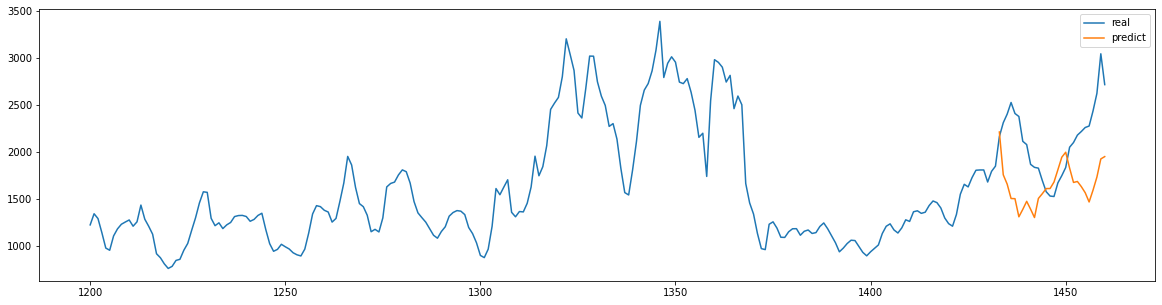

[ 0.19690523 -0.04997984 -0.1036297  -0.18662608 -0.18749643 -0.29204466
 -0.24933012 -0.20281155 -0.24809966 -0.29629391 -0.18626218 -0.15906186
 -0.12936973 -0.12900126 -0.09170509 -0.02055872  0.05159449  0.08017399
 -0.01112426 -0.09394026 -0.08840459 -0.11797327 -0.15325688 -0.20650411
 -0.138547   -0.06261534  0.04162781  0.05501609]
0.1367840764550057
20
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.013472: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1662.0143, 1691.2429, 1766.498, 1876.4465, 1854.4596, 1761.206, 1695.3114, 1696.7002, 1727.1221, 1762.9717, 1846.777, 1936.6733, 1828.4966, 1750.4618, 1927.4537, 1874.8887, 1900.3087, 1984.7081, 2079.2646, 2043.597, 2022.4677, 2034.1481, 2038.1237, 2053.5942, 2110.1506, 2127.2043, 2172.6477, 1904.0369]
[1462.9196983593515, 1308.8442670909583, 1218.2174222433864, 1254.9530059299736, 1202.9237196680963, 1156.3908796128749, 1129.433466435486, 1168.468485037455, 1213.5704266174018, 1320.1205693693846, 1455.8573839758724, 1551.3269951640725, 1507.2747758530943, 1493.7522983775816, 1486.0545947433673, 1446.3314952038988, 1217.0151429347097, 1165.3115713624327, 1172.4735076567708, 1253.491985554093, 1316.3493809871018, 1214.9594963327108, 1115.3825952103496, 1089.92716559695, 1165.0940098763017, 1296.0505957087933, 1638.6253483553678, 1901.5867058992742]


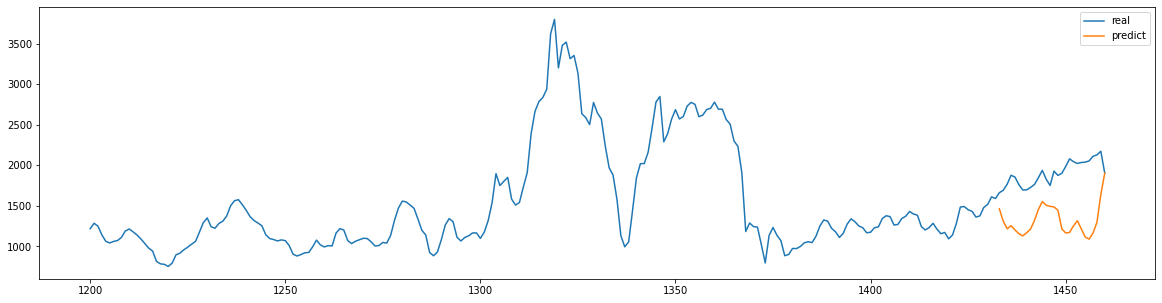

[-0.07988751 -0.17679421 -0.23379454 -0.21068946 -0.2434136  -0.27268073
 -0.28963576 -0.26508444 -0.23671729 -0.16970191 -0.0843294  -0.02428319
 -0.05199011 -0.06049515 -0.06533667 -0.09032076 -0.23455072 -0.26707
 -0.26256546 -0.21160838 -0.17207383 -0.23584363 -0.29847314 -0.31448349
 -0.26720684 -0.18484087  0.03062366  0.19601485]
0.18680391377175493
21
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.011479: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[545.88617, 498.7947, 460.59186, 419.21988, 429.71616, 369.19205, 420.62827, 458.58606, 414.0068, 420.20285, 401.9882, 397.01855, 519.88666, 417.962, 586.6245, 477.755, 455.6433, 382.19021999999995, 535.7536, 349.59784, 390.11812999999995, 332.78656, 450.25275, 425.08325, 428.63916, 417.25327, 481.95395, 545.0128]
[558.6543534232363, 586.0979097598508, 575.7982532467797, 569.2335141133353, 529.9150300660774, 529.7648761649057, 526.1080183550745, 509.00914516256597, 485.26711121477484, 490.6184472939789, 453.49988340839144, 461.07201223687525, 439.1961381890296, 440.04375374290345, 460.311748921895, 462.3969158265769, 438.3872334694445, 419.02255239033695, 421.36474176424736, 417.57618321371075, 414.09211617801185, 426.8623698561668, 419.50082888571023, 475.5022802780449, 452.5915350610554, 470.6201636462867, 481.30711240169404, 487.55148719899654]


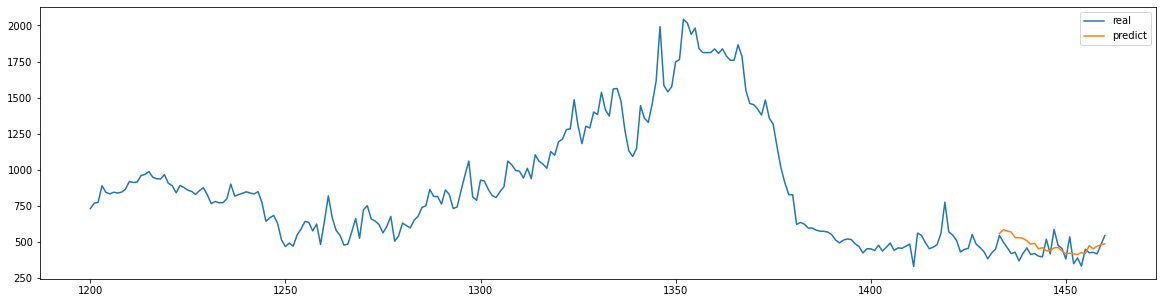

[ 0.23728946  0.29807055  0.27525921  0.26071984  0.17363854  0.17330598
  0.1652069   0.12733687  0.07475378  0.08660575  0.00439676  0.02116727
 -0.0272827  -0.02540543  0.01948346  0.02410162 -0.02907424 -0.07196251
 -0.0667751  -0.07516588 -0.08288227 -0.05459913 -0.07090323  0.05312696
  0.00238498  0.0423142   0.06598331  0.07981315]
0.0960360390315892
22
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.008045: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[481.2189, 479.47018, 472.30942, 460.53107, 489.76694, 475.89252, 468.6032, 444.7358, 475.30685, 517.306, 545.00494, 700.73895, 750.3588, 621.2177, 652.7121, 624.5315, 588.2225, 549.65076, 547.58746, 540.91504, 533.5107, 562.566, 580.956, 601.0856, 633.5133, 661.9567, 774.3446, 719.6531]
[501.2989659280297, 513.3192454077875, 572.1643887343496, 596.038338393738, 638.707539460057, 596.7118862241158, 501.0418113156185, 464.90737785720586, 406.95661350585465, 386.6173941656423, 397.01367491455676, 403.62080634920835, 384.53484869115357, 378.3059369263411, 358.5361605280983, 355.8258912823844, 334.24528764546153, 348.42720189720393, 316.054584623518, 380.4442876774645, 421.79602399943826, 421.0277731134785, 442.56097255127787, 425.08562522977235, 418.56555950751067, 414.7832442986214, 423.8004578880382, 403.0461094418359]


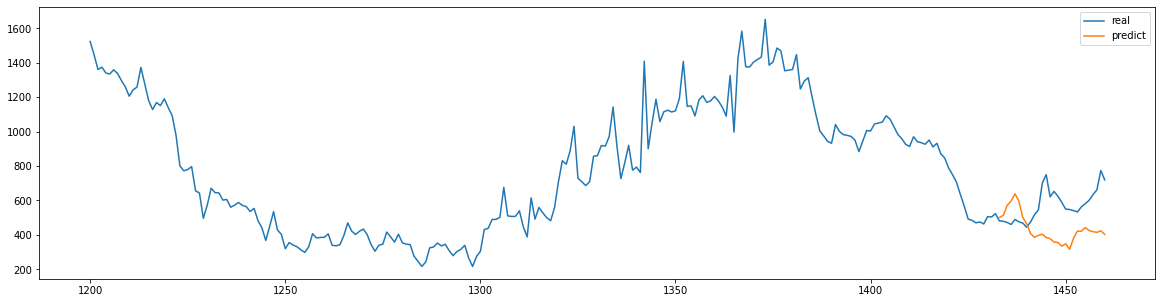

[-0.04227988 -0.01931541  0.09310688  0.13871751  0.22023604  0.14000431
 -0.04277116 -0.11180517 -0.22251877 -0.26137638 -0.24151452 -0.22889175
 -0.26535503 -0.27725522 -0.31502493 -0.32020283 -0.36143208 -0.33433786
 -0.396185   -0.27316995 -0.19416841 -0.19563614 -0.15449746 -0.18788371
 -0.20034014 -0.20756617 -0.19033899 -0.22998969]
0.2094971923539681
23
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.017074: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2057.0378, 2571.0745, 2693.6482, 2710.325, 2692.064, 2546.4229, 2342.6729, 2388.851, 2562.719, 2662.8403, 2839.9636, 2994.3977, 2609.962, 2497.8801, 2682.0715, 3328.7778, 3498.9563, 3426.5342, 3263.5322, 3126.3008, 3193.1018, 3383.2205, 3995.5166, 4328.7188, 4272.5605, 3914.465, 4544.9883, 3648.2324]
[2614.8041616675287, 2969.847508028978, 3056.5375940870076, 2991.2894715983034, 3209.8956178546846, 3040.2537728021234, 3130.3138666568607, 2704.161366645795, 2633.5078035002025, 2074.3608446785424, 1966.621030280748, 1898.4637470831215, 1881.9335234343857, 1869.0918685051263, 1869.586763919553, 1924.0881294429882, 2108.372046697043, 2341.4531446183205, 2240.3011512872026, 2457.540764967139, 2113.3785693935943, 1886.4163141732006, 1724.4718101647868, 1873.0391447731704, 2063.1682935698973, 2154.1973908540654, 2181.4896633481058, 2144.366608542831]


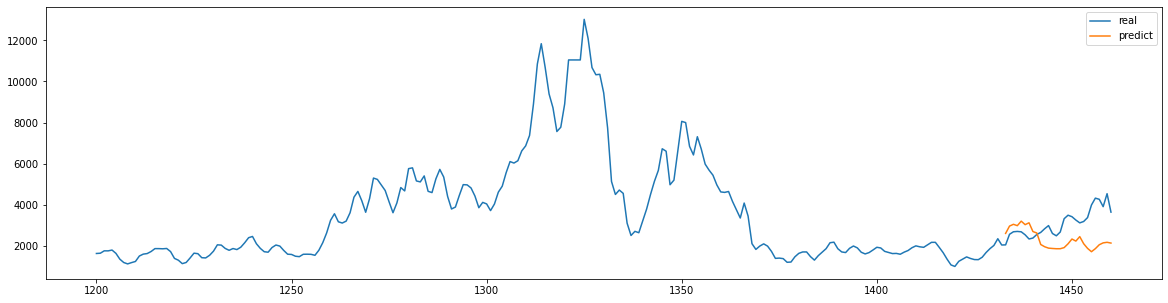

[ 0.27531117  0.44847548  0.49075659  0.45893331  0.56555347  0.48281453
  0.52673929  0.31889311  0.28443345  0.01172225 -0.04082539 -0.07406755
 -0.08212979 -0.08839301 -0.08815164 -0.06156984  0.02831044  0.14199044
  0.09265586  0.19860953  0.03075226 -0.07994341 -0.15892815 -0.08646782
  0.00626334  0.05066071  0.06397189  0.04586597]
0.18868534627011346
24
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.020019: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[587.4107, 617.8336, 639.5589, 619.14215, 665.06665, 657.7403, 740.5727, 663.2868, 631.56244, 731.4091, 822.0903, 788.3752, 786.9283, 800.85675, 789.5009, 966.50073, 903.1354, 857.5891, 710.13336, 649.10345, 504.8356, 564.9086, 538.8198, 583.841, 555.51227, 576.6337, 786.80066, 714.2151]
[777.3788370630723, 825.5530131703836, 884.0111828734995, 856.9561038510183, 855.3493159702983, 795.7126119625223, 866.950239718334, 932.2300259134835, 935.8111854162507, 802.93010273673, 795.3026179346341, 697.8029468641603, 781.9716023245817, 755.846572596299, 787.9111228159779, 932.8105476894897, 927.332053192197, 798.537737423535, 879.5949246869294, 921.9707158025687, 995.6751932887983, 1068.8433743760359, 1053.3262777858722, 1132.3812719301795, 1186.501823985908, 906.4940328994667, 836.5212086032407, 832.9418990965127]


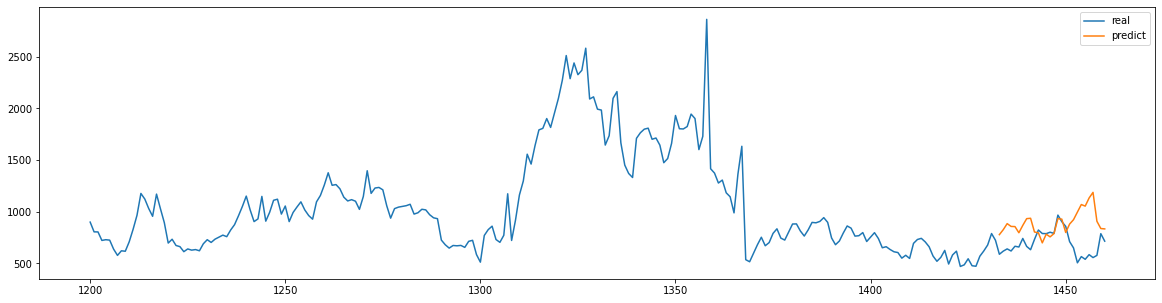

[ 0.07511805  0.14174313  0.22259101  0.18517373  0.18295154  0.10047374
  0.19899566  0.28927787  0.29423063  0.11045556  0.09990671 -0.03493572
  0.08146987  0.04533884  0.08968425  0.29008073  0.28250395  0.1043809
  0.21648331  0.2750892   0.37702279  0.47821468  0.45675447  0.56608785
  0.64093679  0.25368489  0.15691219  0.15196199]
0.22865928727222282
25
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.040785: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1925.1821, 1977.04, 2001.7733, 2016.8643, 1940.1483, 1879.0133, 1791.2472, 1761.257, 1808.2974, 1889.265, 1979.8068, 2093.3953, 2073.7, 2065.9536, 2135.848, 2283.4338, 2305.6384, 2353.7363, 2360.8599, 2330.2676, 2295.2112, 2245.2314, 2277.3945, 2298.7866, 2351.537, 2377.7886, 2806.1501, 2638.6118]
[1951.0425441628645, 2034.046653025563, 1970.9636768692296, 1956.7629005786578, 1804.3459499084354, 1687.49775630078, 1620.0729188840062, 1597.5529599677534, 1625.4370051301448, 1693.1639966360808, 1679.1292599487692, 1638.1293404750616, 1668.1170317916005, 1546.8062326588094, 1597.032298764178, 1720.2392214258894, 1832.6310991588234, 1869.6615862091571, 1677.6586285825313, 1611.1296452479273, 1539.9726618772775, 1668.7679299729973, 1831.1044522735058, 1989.6155993361044, 1970.66590403228, 2015.4763929784979, 1875.2716139138265, 1827.7789295310677]


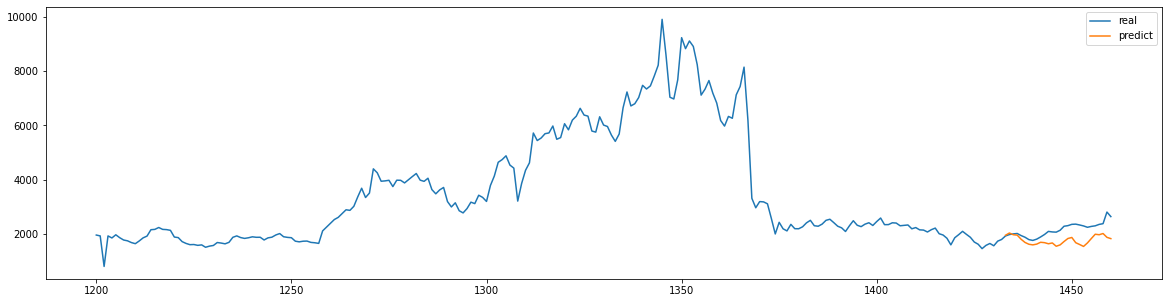

[ 0.08623296  0.13244507  0.09732395  0.08941774  0.00456038 -0.06049425
 -0.09803269 -0.11057056 -0.09504626 -0.0573396  -0.06515337 -0.08797987
 -0.07128437 -0.13882354 -0.11086043 -0.04226561  0.02030799  0.04092453
 -0.06597214 -0.10301181 -0.1426281  -0.07092199  0.01945804  0.10770831
  0.09715816  0.12210618  0.04404788  0.01760657]
0.0785600839859644
26
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.014005: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[5257.3037, 5447.6367, 4751.1523, 4602.1626, 4202.835, 3661.1235, 2948.9468, 3343.9224, 3471.5608, 3713.4543, 3916.9785, 3134.1528, 2679.8684, 2300.1096, 2747.0767, 3742.3806, 3890.995, 4218.617, 4368.2915, 3246.5322, 3392.1445, 3438.3704, 3004.5393, 3289.1448, 3830.4802, 3887.3884, 4703.8086, 3145.7773]
[4043.547279571694, 4122.028396442485, 4315.310185828757, 3654.582271083397, 3308.607658173841, 2779.370761183788, 2760.77388500641, 3057.6716244291038, 3205.4187904435666, 3618.8275499537112, 3248.6369565244286, 2878.3769067158446, 2633.5045057097905, 2586.4052594470318, 2541.656523779965, 2997.041276396391, 3179.0321277725966, 3525.4049101620435, 3310.594721171957, 2468.3991185761165, 2192.2424387884785, 2327.9421271205406, 2712.114229152863, 3147.0741199042172, 3070.080222302255, 2642.6996422565066, 2289.0124194113996, 1967.4558866679195]


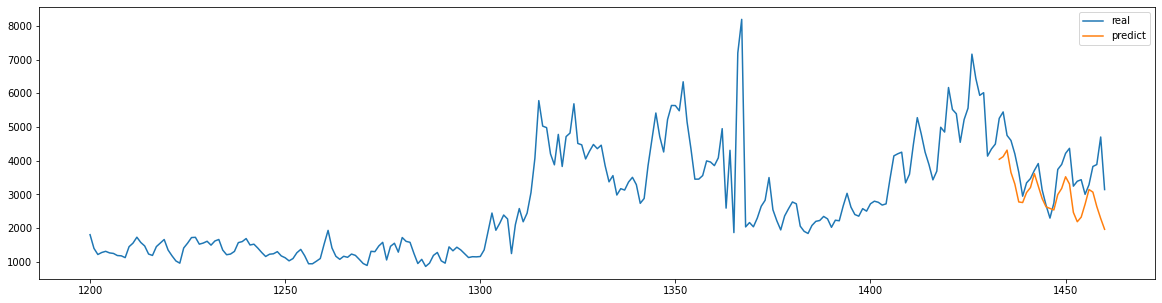

[-0.10047785 -0.08301904 -0.04002183 -0.18700648 -0.26397154 -0.38170487
 -0.38584191 -0.31979443 -0.2869268  -0.19496043 -0.27731254 -0.3596801
 -0.41415409 -0.42463172 -0.43458647 -0.33328218 -0.29279674 -0.21574311
 -0.2635295  -0.45088321 -0.51231666 -0.48212909 -0.39666667 -0.29990607
 -0.31703403 -0.41210855 -0.49078934 -0.56232238]
0.3279856297897369
27
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.015848: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[4325.097, 4325.337, 4469.5186, 4724.459, 5268.5967, 5699.7866, 5357.753, 5339.6885, 5510.5176, 5722.606, 5941.6147, 6054.6, 5650.527, 5209.389, 5499.8496, 6519.8013, 7100.035, 7587.3394, 7999.2197, 7822.471, 7290.104, 7866.495000000001, 9600.829, 10124.349, 11269.19, 10485.831, 11090.785, 9655.353]
[4995.016529175672, 5312.43379556892, 5289.763248330188, 4798.235256653524, 4502.439527797246, 4313.440412886191, 4699.7026438450575, 4673.981472304392, 4839.389968597246, 4951.480959266123, 4854.032777535796, 4958.530399761256, 4639.960454096532, 4807.208010201788, 5267.593419472838, 5534.894261916518, 5678.147115951681, 5347.717565539384, 5271.057007388282, 4955.433659985873, 5323.045155525231, 5866.563425133705, 5709.324280450106, 5230.13209670012, 5038.644691014299, 4786.2506121912, 4638.438842012906, 4745.663003251696]


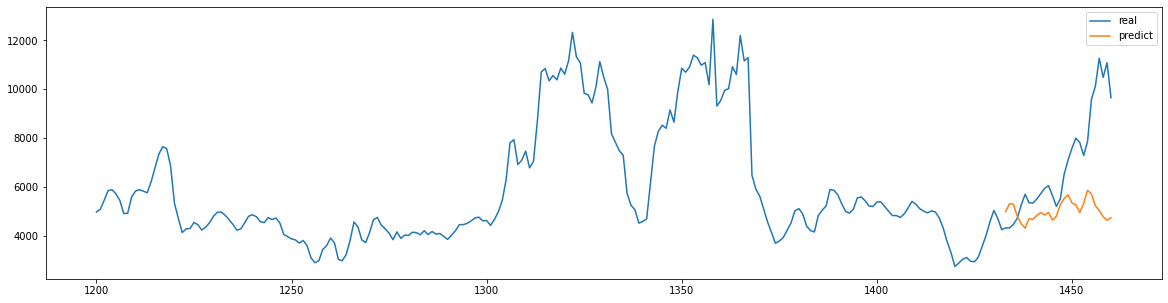

[0.17458643 0.24922763 0.24389661 0.12831299 0.05875613 0.01431267
 0.10514288 0.0990945  0.13799058 0.16434897 0.14143387 0.16600665
 0.0910944  0.13042294 0.23868334 0.30153957 0.33522572 0.25752466
 0.23949781 0.16527845 0.2517229  0.37953213 0.34255708 0.22987424
 0.18484566 0.12549478 0.09073659 0.11595053]
0.1843960973349843
28
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.007091: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[401.64133, 368.65527, 384.83566, 394.45642, 389.01593, 374.2231, 379.25983, 348.71222, 374.1375, 379.53308, 384.9265, 401.17004, 419.41257, 461.35898, 449.72037, 463.267, 501.58453, 546.1627, 534.58215, 491.76657, 478.08017, 454.01855, 465.16766, 466.36606, 464.81906, 497.1702, 510.41052, 532.60364]
[400.4222450363322, 417.9773503749469, 409.1244147754734, 413.0310856607108, 419.1349445261319, 437.2752589675187, 468.5669066706864, 429.0712353135665, 482.6422917793253, 472.920369300645, 443.2803086790403, 437.10335217538136, 416.9311305203338, 407.27334416518465, 414.145008279437, 413.92623318809706, 394.00888631099065, 353.02341465203824, 344.458478674666, 375.1813304266286, 388.51423607652396, 418.11391307989527, 413.4916155765623, 337.4421093471146, 351.5294096772531, 364.33331119603577, 376.35406298561696, 391.21183694013314]


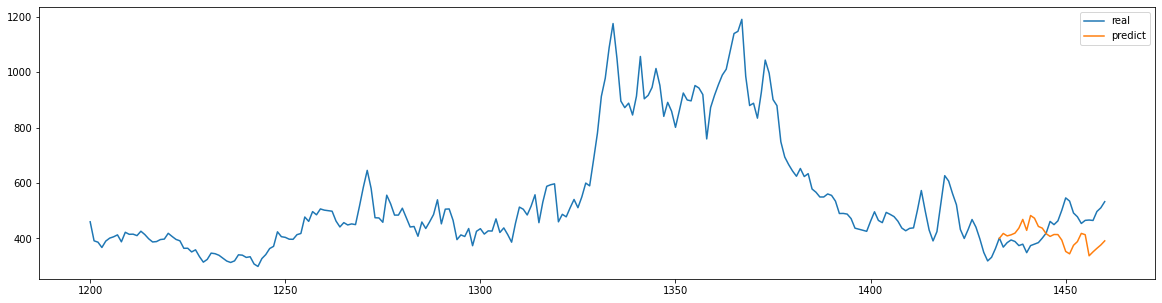

[ 0.10108143  0.14935447  0.12501066  0.13575323  0.15253762  0.20241988
  0.28846568  0.17986045  0.32717018  0.30043683  0.21893257  0.20194717
  0.14647758  0.11992059  0.13881629  0.13821471  0.08344597 -0.02925592
 -0.05280778  0.03167394  0.06833677  0.14972999  0.13701959 -0.0721014
 -0.03336413  0.00184405  0.03489872  0.07575464]
0.13202257983782836
29
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.015938: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[718.5471, 680.7191, 717.5116, 697.72504, 702.2162, 717.3337, 708.0527, 723.4309, 708.08936, 761.7928, 787.8609, 794.7738, 766.526, 812.4503, 855.0534, 874.19934, 854.5841, 874.9029, 802.66376, 864.4115, 840.10114, 859.9852, 872.6113, 874.41846, 856.2725, 838.168, 940.0504, 836.78925]
[850.3950162217773, 849.9125408646023, 812.6167508908666, 854.9143907975472, 901.4744962517954, 821.7167295219338, 952.1672933129779, 823.9352668788946, 819.0206103130972, 847.0065873396969, 932.7098770682952, 895.4011102060235, 896.433882477287, 909.385029557643, 883.3010084046876, 877.681302874992, 902.3793903102016, 868.0435037462389, 920.1815783874667, 848.7082128125227, 848.3362457465029, 838.180665226475, 819.6163238094247, 995.2892057672075, 1031.6103490109285, 955.505022851417, 941.1623155332766, 990.1298891022777]


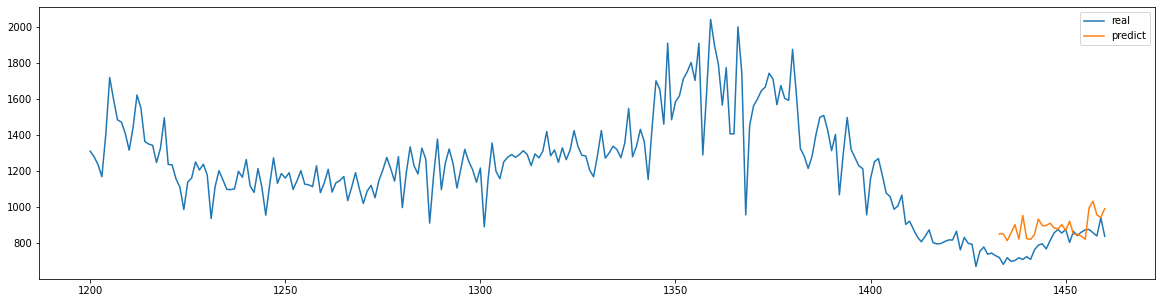

[0.16607806 0.16541648 0.11427577 0.17227511 0.23611923 0.12675384
 0.30563017 0.12979594 0.12305687 0.16143178 0.27894978 0.22779128
 0.22920744 0.2469663  0.21119939 0.20349354 0.23736004 0.19027801
 0.26177074 0.16376508 0.16325503 0.1493295  0.12387372 0.36475977
 0.41456402 0.31020693 0.29053993 0.35768521]
0.2187796061690713
30
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.004306: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1126.2366, 1160.9956, 1114.893, 1074.7896, 1160.402, 1156.7736, 1140.0345, 1143.6372, 1153.383, 1148.1139, 1161.0034, 1165.2231, 1166.1467, 1134.9882, 1256.6322, 1144.3676, 1171.7878, 1176.055, 1217.5851, 1211.7382, 1221.6616, 1199.5154, 1240.1261, 1228.6682, 1241.5958, 1226.1412, 1214.0131, 1219.3773]
[920.5900787965626, 970.8861189254791, 1027.3390873877406, 1028.9292115097523, 1077.9005270554483, 1108.5138122098447, 1100.7967675882817, 954.6710220986993, 923.7988102269352, 938.1259361232072, 962.7685910015434, 913.4279642634988, 909.5127112073511, 884.972803706342, 895.8964591122866, 873.3621005806178, 891.0226879286528, 909.1603929037929, 894.4491251536667, 893.743102503419, 892.717832538727, 958.652417133075, 915.4028816796363, 894.4687515244067, 854.3354914942638, 887.2501973150343, 864.7014793765247, 900.768622485888]


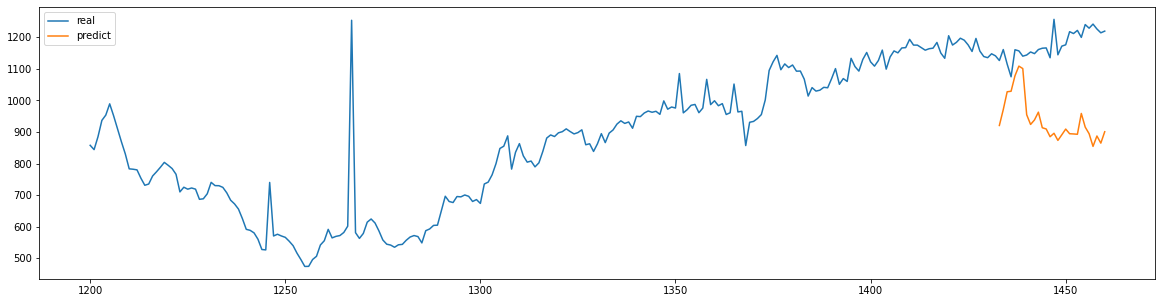

[-0.19324266 -0.14916582 -0.09969337 -0.09829987 -0.05538395 -0.02855605
 -0.03531887 -0.16337589 -0.19043069 -0.17787514 -0.1562796  -0.19951916
 -0.20295029 -0.22445579 -0.21488286 -0.2346308  -0.21915398 -0.20325904
 -0.21615123 -0.21676995 -0.21766845 -0.1598868  -0.19778845 -0.21613403
 -0.25130474 -0.22246    -0.24222052 -0.21061315]
0.17848111201889605
31
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.016101: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2618.647, 2589.3533, 2553.7605, 2450.8674, 2403.6323, 2282.84, 2212.309, 2214.5056, 2227.7188, 2418.1096, 2539.0806, 2584.8445, 2407.2012, 2242.0547, 2314.0996, 2465.689, 2617.7532, 2734.6255, 2962.9465, 3151.9358, 3213.8523, 3115.1965, 3210.351, 3270.2515, 3261.398, 3199.7664, 3097.5002, 2548.2266]
[2733.105685676658, 2762.7271121546923, 3193.3800844493016, 3174.645351650883, 3146.8212514236957, 2972.9340327142822, 2752.948125784975, 2766.94299153834, 2998.3394850336, 3052.612582168454, 3113.69052924027, 3132.490609448598, 3242.751699353099, 3205.137358216779, 2983.267121523504, 2936.7374673721924, 2802.665278742588, 2708.556147003311, 2821.7658433064194, 2849.8706909810408, 2886.288816740124, 2899.192916227131, 2892.8914166803524, 2886.9098540719406, 2797.468572172344, 3065.186698559806, 3345.9487176606954, 3401.3880575572907]


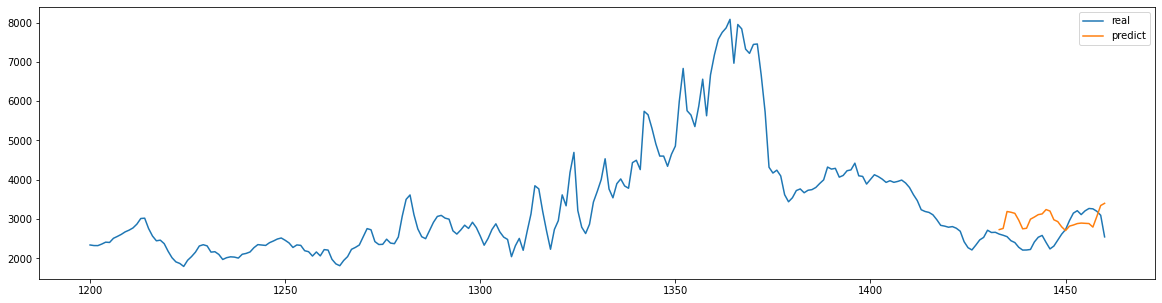

[0.02574674 0.0368638  0.19848978 0.19145855 0.18101604 0.11575539
 0.0331937  0.03844604 0.12529017 0.14565911 0.16858193 0.17563769
 0.21701916 0.20290233 0.11963345 0.10217066 0.05185277 0.01653319
 0.0590213  0.06956917 0.08323706 0.08808002 0.08571504 0.08347013
 0.04990242 0.15037823 0.25574946 0.2765561 ]
0.11956890752074055
32
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.007842: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[4683.2085, 5597.0703, 5096.3076, 5121.5903, 5555.115, 5250.3135, 5049.0864, 4685.079, 5070.6685, 5139.2817, 5345.188, 5190.4385, 5130.3486, 4611.7866, 4986.6714, 5125.4644, 5099.3906, 4776.3774, 5467.6997, 5213.083, 5265.3857, 5250.6953, 5271.8574, 4965.25, 5015.1655, 4617.2715, 5105.517, 5228.6533]
[4903.430659724367, 5030.570677384209, 5053.242313187588, 5093.286276795411, 5225.063040965032, 4834.176624564945, 4625.3748808955725, 4625.010342922253, 4588.066674144804, 5019.948490729082, 4763.466105755108, 5129.839953442263, 4396.9369500385765, 4381.47061661545, 4603.38055169571, 4586.275788521224, 4756.079987373918, 4754.141435349571, 4806.406354235107, 4614.151588665896, 4627.003624075454, 4637.274242000186, 4583.772724636805, 4350.308969982296, 4650.113361981105, 4603.631702968442, 4279.113853527087, 4389.151529655313]


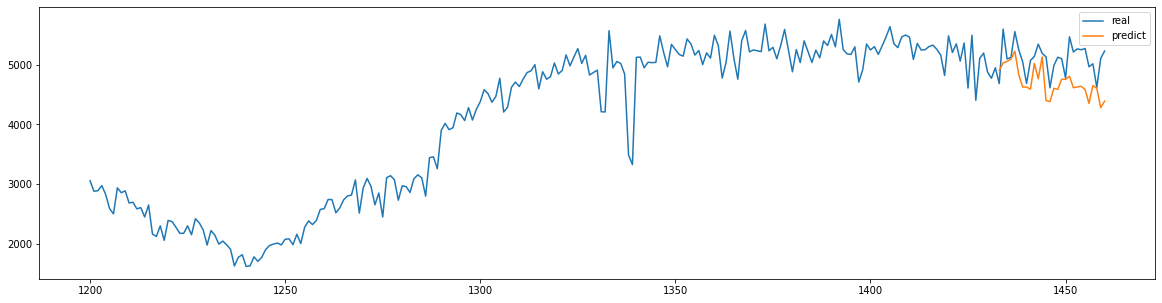

[-0.00911849  0.01657387  0.02115533  0.02924739  0.05587674 -0.02311329
 -0.06530779 -0.06538145 -0.072847    0.01442734 -0.03740242  0.03663413
 -0.11147035 -0.11459578 -0.06975239 -0.0732089  -0.038895   -0.03928674
 -0.02872509 -0.06757578 -0.06497865 -0.06290317 -0.07371472 -0.1208929
 -0.06030866 -0.06970163 -0.13527995 -0.11304362]
0.060407806453406064
33
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.008891: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[4979.9565, 5145.621, 5117.442, 5091.5635, 5203.5493, 5049.3677, 4956.37, 5244.2764, 5159.041, 5074.2095, 5219.955, 5172.781, 5292.838, 2667.6602, 5519.858, 5253.974, 5129.3613, 4616.586, 5561.873, 5783.832, 5644.6606, 5081.479, 5210.158, 5036.3276, 4839.1104, 3874.6033, 5751.2124, 4897.0967]
[5157.3029907349, 5471.221587530468, 5792.593589942557, 5988.970100315064, 6328.15353163743, 6290.100726333678, 6233.66851702007, 5441.207089002774, 5289.7575404860245, 5518.609825192904, 5822.046445530605, 5616.422261397803, 5919.086207098269, 5839.876961596, 6154.574973227679, 6338.603439256692, 6519.123374856579, 6928.4332256549, 6266.085307057989, 6207.865464011609, 5783.912395139038, 5884.652918816817, 6437.322386872947, 7096.264056803071, 7483.77543947935, 7523.749231688284, 7326.753348421621, 7140.210637085784]


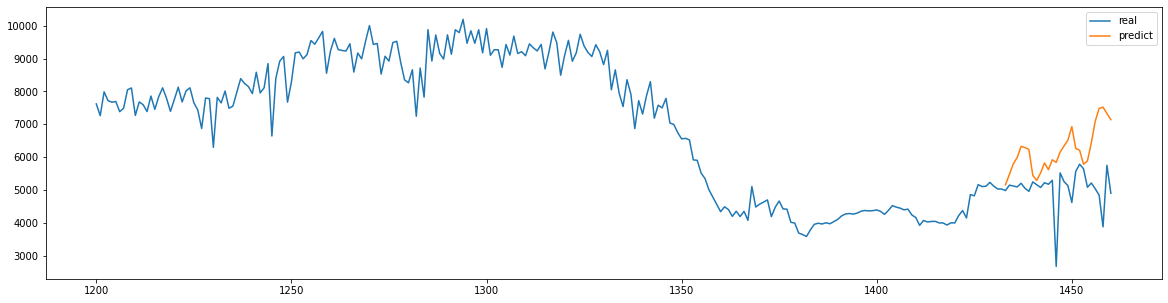

[0.02588573 0.08833011 0.15225712 0.19132015 0.25879019 0.25122076
 0.23999532 0.08235966 0.05223346 0.09775654 0.15811586 0.11721329
 0.17741891 0.16166268 0.22426211 0.26086887 0.29677773 0.37819725
 0.24644364 0.2348626  0.15053027 0.17056948 0.28050595 0.41158199
 0.48866538 0.49661693 0.4574307  0.4203238 ]
0.23472130301082786
34
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.007885: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[2253.134, 2337.3992, 2459.09, 2589.408, 2532.111, 2447.075, 2452.4866, 2509.5208, 2537.6804, 2676.1123, 2827.3972, 2989.9795, 2782.694, 2825.6382, 2954.5054, 2874.3179, 2947.0547, 3044.6428, 3679.7234, 3701.1338, 3654.4941, 3900.962, 4823.667, 5060.9893, 5177.3584, 5251.819, 4690.3345, 3998.763]
[1998.8632650508641, 2134.3505151716945, 2015.5787728034616, 2290.749637276596, 2698.0115045794364, 2922.1906591822503, 2899.5292111811996, 2682.348946812564, 2539.864630085909, 2498.7168009412885, 2610.2650211398723, 2537.569658931893, 2326.139555281985, 2258.169279268992, 2333.270528312665, 2336.5152841912327, 2567.85966998595, 2623.85756533612, 2924.7086991617202, 3026.593333605717, 2920.091923465049, 2535.3497170587298, 2191.1922294131277, 2415.158801053524, 2445.280321873581, 2582.257671748441, 2870.4506103909193, 2803.8660965382696]


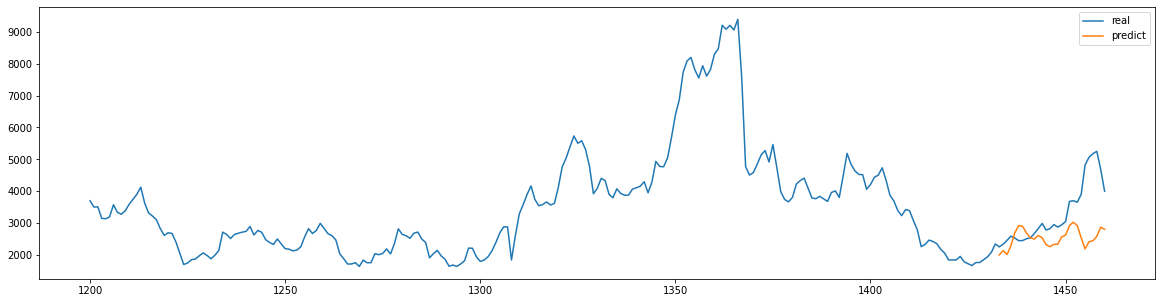

[-0.14799722 -0.09024664 -0.14087234 -0.02358251  0.15001027  0.24556522
  0.23590592  0.14333421  0.08260117  0.06506217  0.11260889  0.08162296
 -0.00849778 -0.03746968 -0.00545825 -0.00407519  0.09453388  0.11840263
  0.24663851  0.29006619  0.24467064  0.08067672 -0.06601822  0.02944611
  0.04228521  0.10067094  0.22351135  0.19513012]
0.11810574910589025
35
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.022896: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1974.3525, 2243.585, 2295.2778, 2334.8145, 2372.4888, 2104.2346, 2035.1422, 2047.6442, 2106.1194, 2178.956, 2262.8052, 2170.6445, 2125.5256, 2016.7755, 2085.1045, 2146.7866, 2293.9458, 2460.287, 2567.9697, 2553.372, 2627.0278, 2625.1907, 2866.3044, 2944.1497, 3004.655, 2674.355, 2813.8179, 2809.6008]
[2056.7599049639584, 1997.4133304662823, 2015.8201038012594, 2060.2063517067313, 2121.087186065632, 2205.0533513697064, 2156.6687186191684, 2086.0966218497424, 2084.16680869402, 2181.884722206185, 2223.723146712125, 2288.189683295768, 2356.7236629538593, 2400.7969829239128, 2417.7887112280846, 2327.156309260988, 2365.015048252648, 2307.62157751649, 2274.4165267287253, 2211.4349421754578, 2192.8069080854243, 1941.55315208129, 1905.7651836654723, 2020.2868338794797, 2104.400588445354, 2090.4920728232173, 2081.940304180786, 2131.314554595659]


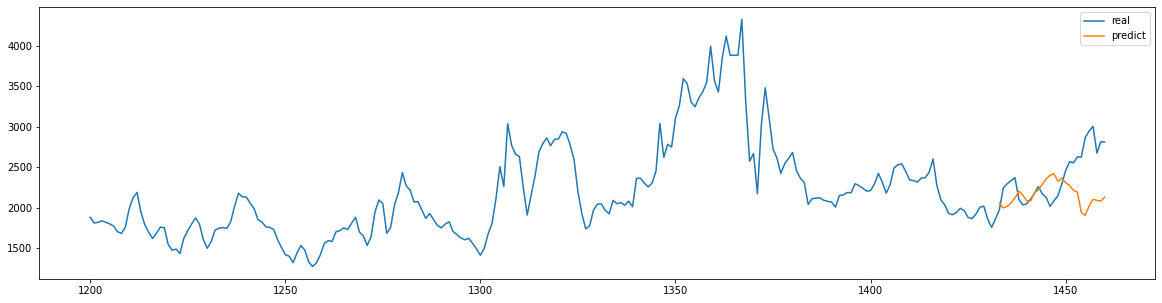

[0.10546918 0.07357153 0.08346482 0.10732158 0.14004387 0.18517408
 0.15916826 0.12123711 0.12019987 0.17272138 0.19520874 0.22985827
 0.26669398 0.29038254 0.29951527 0.25080209 0.27115044 0.24030254
 0.22245546 0.18860406 0.17859185 0.04354775 0.0243124  0.0858656
 0.13107514 0.12359958 0.11900317 0.14554088]
0.16338862349303082
36
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


loss: 0.009145: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
[1254.6967, 1304.751, 1346.6581, 1360.1616, 1372.9166, 1428.5106, 1396.3281, 1423.6389, 1436.9102, 1505.0325, 1544.8698, 1568.9359, 1654.5408, 1753.2927, 1843.274, 1842.8859, 1918.8735, 2012.2961, 2127.5957, 2101.2205, 2003.7411, 2001.3851, 2063.0703, 2243.886, 2428.668, 2512.5488, 2665.3496, 2282.687]
[1155.861750635898, 1241.3081743368207, 1455.4031933150768, 1474.4417726148783, 1493.459882448837, 1425.048844141209, 1326.0853345684916, 1286.9404559824793, 1256.616585478109, 1288.1947853280096, 1391.4722616758286, 1443.424324438387, 1370.374385379508, 1316.4927371673614, 1278.8197055350543, 1269.3595260320574, 1283.8140618899076, 1341.3030614655106, 1342.4313736482918, 1267.466991819173, 1164.2365759117126, 1142.2481167588949, 1173.0136594837545, 1226.9783883820296, 1271.5004646231919, 1299.3919912446231, 1300.2594841999858, 1128.8136605146944]


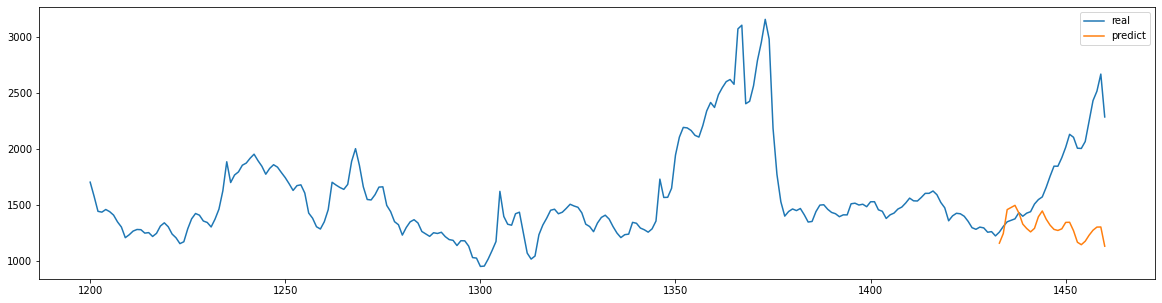

[-0.05306676  0.01693474  0.19233088  0.20792813  0.22350861  0.16746325
  0.08638796  0.05431873  0.02947607  0.05534634  0.13995583  0.18251726
  0.12267151  0.07852927  0.04766585  0.03991566  0.05175745  0.09885499
  0.09977936  0.03836521 -0.04620573 -0.06421965 -0.03901515  0.00519515
  0.04166961  0.06451958  0.06523027 -0.07522575]
0.08528767071179896
0.20634391399297358


In [90]:
sum_of_error=0
values = ['value','value2','value3']
for j in range(37):
  print(j)
  print(f'torchseed={torch.random.seed},npseed{np.random.seed}')
  %cd /content/drive/MyDrive/imputation_traindata/
  data = pd.read_csv(f"train2_{j}_imputated.csv", encoding='utf-8')
  %cd /content/drive/MyDrive/
  data["date"] = pd.to_datetime(data['datadate'].astype(str), format='%Y%m%d') #날짜변환
  data["value"] = data["해당일자_전체평균가격(원)"]
  data['value2'] = data["하위가격 평균가(원)"]
  data["value3"] = data["상위가격 평균가(원)"]
  #data['value4'] = data['일자별_도매가격_평균(원)']
  #data['value5'] = data['일자별_소매가격_평균(원)']
  data=data.fillna(method='ffill') #이전값으로 결측치 채우기
  if(data['value'][0]==np.nan):
    data[0]=data[1]
  data=data.fillna(0)

  robust_scaler_value =RobustScaler() ##########
  data = data[["date", "value","value2","value3"]]
  data[values]=robust_scaler_value.fit_transform(data[values])
  data_train = data.iloc[:-28].copy() ########

  pred_len = 28
  """
  모델이 decoder에서 결과를 만들 때 label_len만큼 이전 데이터를 참고한다는 특징이 있어서 
  input의 길이가 seq_len이고 output의 길이가 pred_len일 때 intput과 output의 형태는 아래와 같다.
  input: [0, seq_len]

  output: [seq_len - label_len:seq_len + pred_len] 0~14+28
  """
  seq_len = 14#인풋 크기 ->나중에 2주로 바꾸기..?
  label_len = 14#디코더에서 참고할 크기
  pred_len = 28#예측할 크기 (4주)

  batch_size = 28 ##
  shuffle_flag = True
  num_workers = 0
  drop_last = True

  dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

  enc_in = 3 #차원 개수
  dec_in = 3
  c_out =3



  device = torch.device("cuda:0") #gpu = CUDA:0

  model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
  learning_rate = 1e-4
  criterion =  nn.MSELoss()
  model_optim = optim.Adam(model.parameters(), lr=learning_rate)
 ################################## 여기까지 기본설정 #####################

  train_epochs = 100
  model.train()
  progress = tqdm(range(train_epochs))
  for epoch in progress:
      train_loss = [] 
      for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
          model_optim.zero_grad()
          pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
          loss = criterion(pred, true)
          train_loss.append(loss.item())
          loss.backward()
          model_optim.step()
      train_loss = np.average(train_loss)
      progress.set_description("loss: {:0.6f}".format(train_loss))
  torch.save(model.state_dict(), f'multi_informer_train{j}_2.pt') #trainx_y x는 훈련번호 y는 차원개수

  ###############################여기까지 학습 ############ 아래부터 테스트시작
  for k in range(1):
    %cd /content/drive/MyDrive/imputation_traindata/
    new_data = pd.read_csv(f"train2_{j}_imputated.csv", encoding='utf-8')
    %cd /content/drive/MyDrive/

    new_data["value"] = new_data["해당일자_전체평균가격(원)"]
    new_data['value2'] = new_data["하위가격 평균가(원)"]
    new_data["value3"] = new_data["상위가격 평균가(원)"]
    #new_data['value4'] = new_data['일자별_도매가격_평균(원)']
    #new_data['value5'] = new_data['일자별_소매가격_평균(원)']
    new_data.fillna(method='ffill')
    new_data.fillna(0)

    scaler = dataset.scaler
    df_test = data_train.copy()
    ################
    df_test[values]=robust_scaler_value.transform(new_data[values])[:-28] #######

    delta = df_test["date"][1] - df_test["date"][0]
    for i in range(pred_len):
        df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
    df_test = df_test.fillna(0)

    df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()  #-42~-28
    df_test_y = df_test.iloc[-label_len-pred_len:].copy()  #-42~0

    df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
    test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
    test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


    test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
    test_data_y =df_test_numpy[-label_len-pred_len:]
    test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



    test_time_x = test_time_x #14*3
    test_time_y = test_time_y #42*3
    test_data_y = test_data_y.astype(np.float64)
    test_data_x = test_data_x.astype(np.float64)

    _test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
    _test_loader = DataLoader(_test,batch_size=1,shuffle=False)

    

    preds = []


    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()


    #28*2
    
    df_test.iloc[-pred_len:, 1:] = preds[0]
    
    real = data[values].to_numpy()
    result = df_test[values].iloc[-28:].to_numpy()

    real = robust_scaler_value.inverse_transform(real)
    result =robust_scaler_value.inverse_transform(result)
    real2=[]
    result2=[]
    for i in range(28):
      result2.append(result[i][0])
    for i in range(1461):
      real2.append(real[i][0])

    print(real2[-28:])
    print(result2)
    plt.figure(figsize=(20,5))
    plt.plot(range(1200,1461),real2[1200:], label="real")
    plt.plot(range(1461-28,1461),result2, label="predict")
    plt.legend()
    plt.show()

    cri=real2[1461-29]
    ans=(result2-cri)/cri
    print( ans)
    print(np.mean(np.abs(ans)))
    sum_of_error=sum_of_error+(np.mean(np.abs(ans)))
print(sum_of_error/37)

submit2 = 0.18

In [91]:
#오류났을 때 모델 불러오기
"""
model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
model.load_state_dict(torch.load('multi_informer_train1_2.pt'))
model.eval() #모델 불러오기,전처리
"""

"\nmodel = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)\nmodel.load_state_dict(torch.load('multi_informer_train1_2.pt'))\nmodel.eval() #모델 불러오기,전처리\n"

## 정답제출

In [92]:
from pyparsing.helpers import empty
values = ['value','value2','value3']
answer_save=[]
for j in range(37):
  print(f'torchseed={torch.random.seed},npseed{np.random.seed}')
  %cd /content/drive/MyDrive/imputation_traindata/
  data = pd.read_csv(f"train2_{j}_imputated.csv", encoding='utf-8')
  %cd /content/drive/MyDrive/
  data["date"] = pd.to_datetime(data['datadate'].astype(str), format='%Y%m%d') #날짜변환
  data["value"] = data["해당일자_전체평균가격(원)"]
  data['value2'] = data["하위가격 평균가(원)"]
  data["value3"] = data["상위가격 평균가(원)"]
  #data['value4'] = data['일자별_도매가격_평균(원)']
  #data['value5'] = data['일자별_소매가격_평균(원)']
  data=data.fillna(method='ffill') #이전값으로 결측치 채우기
  if(data['value'][0]==np.nan):
    data[0]=data[1]
  data=data.fillna(0)

  robust_scaler_value = RobustScaler()
  data = data[["date", "value","value2","value3"]]
  data[values]=robust_scaler_value.fit_transform(data[values])
  data_train = data.copy() #########

  pred_len = 28
  """
  모델이 decoder에서 결과를 만들 때 label_len만큼 이전 데이터를 참고한다는 특징이 있어서 
  input의 길이가 seq_len이고 output의 길이가 pred_len일 때 intput과 output의 형태는 아래와 같다.
  input: [0, seq_len]

  output: [seq_len - label_len:seq_len + pred_len] 0~14+28
  """
  seq_len = 14#인풋 크기 ->나중에 2주로 바꾸기..?
  label_len = 14#디코더에서 참고할 크기
  pred_len = 28#예측할 크기 (4주)

  batch_size = 28
  shuffle_flag = True
  num_workers = 0
  drop_last = True

  dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

  enc_in = 3 #차원 개수
  dec_in = 3
  c_out =3



  device = torch.device("cuda:0") #gpu = CUDA:0

  model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
  learning_rate = 1e-4
  criterion =  nn.MSELoss()
  model_optim = optim.Adam(model.parameters(), lr=learning_rate)


  model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
  model.load_state_dict(torch.load(f'multi_informer_train{j}_2.pt'))
  model.eval() #모델 불러오기,전처리
  %cd /content/drive/MyDrive/

  answer_save.append([])

  for k in range(10):
    print(f"품목{j}-{k}번째") #2018 05 20 set9 test7
    answer_save[j].append(0)
    testdata=pd.read_csv(f'./data/test/set_{k}/test_{j}.csv')
    testdata["value"] = testdata["해당일자_전체평균가격(원)"]
    testdata["value2"] = testdata["하위가격 평균가(원)"]
    testdata["value3"] = testdata["상위가격 평균가(원)"]
    #testdata['value4'] = testdata['일자별_도매가격_평균(원)']
    #testdata['value5'] = testdata['일자별_소매가격_평균(원)']
    if(testdata.empty):
      answer_save[j][k]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      continue
    testdata=testdata.fillna(method='ffill')
    if(testdata['value'][0]==np.nan):
      testdata[0]=testdata[1]
    testdata=testdata.fillna(0)
    
    testdata["date"] = pd.to_datetime(testdata['datadate'].astype(str), format='%Y%m%d')
    df_test = testdata[["date","value","value2","value3"]]

    
    scaler = dataset.scaler
    

    df_test[values]=robust_scaler_value.transform(testdata[values])

    delta = df_test["date"][1] - df_test["date"][0]
    for i in range(pred_len):
        df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
    df_test = df_test.fillna(0)

    df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()  #-42~-28
    df_test_y = df_test.iloc[-label_len-pred_len:].copy()  #-42~0

    df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
    test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
    test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


    test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
    test_data_y =df_test_numpy[-label_len-pred_len:]
    test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



    test_time_x = test_time_x #14*3
    test_time_y = test_time_y #42*3
    test_data_y = test_data_y.astype(np.float64)
    test_data_x = test_data_x.astype(np.float64)

    _test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
    _test_loader = DataLoader(_test,batch_size=1,shuffle=False)

    #print(test_time_y) #월 일 요일 시간

    preds = []


    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()


    #28*2
    #answer = robust_scaler_value.inverse_transform(preds[0])
    df_test.iloc[-pred_len:, 1:] = preds[0]
    
    real = testdata[values].to_numpy()
    result = df_test[values].iloc[-28:].to_numpy()

    
    result =robust_scaler_value.inverse_transform(result)
    
    real2=[]
    result2=[]
    for i in range(28):
      result2.append(result[i][0])
    for i in range(14):
      real2.append(real[i][0])

    #print(real2)
    #print(result2)
    """
    plt.figure(figsize=(20,5))
    plt.plot(range(0,14),real2, label="real")
    plt.plot(range(42-28,42),result2, label="predict")
    plt.legend()
    plt.show()"""
    
    answer_save[j][k] = (result2-real2[13])/real2[13]
    #print(answer_save[j][k])

torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목0-0번째
품목0-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목0-2번째
품목0-3번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목0-4번째
품목0-5번째
품목0-6번째
품목0-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


품목0-8번째
품목0-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목1-0번째
품목1-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목1-2번째
품목1-3번째
품목1-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목1-5번째
품목1-6번째
품목1-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목1-8번째
품목1-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목2-0번째
품목2-1번째
품목2-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목2-3번째
품목2-4번째
품목2-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목2-6번째
품목2-7번째
품목2-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목2-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목3-0번째
품목3-1번째
품목3-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목3-3번째
품목3-4번째
품목3-5번째
품목3-6번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목3-7번째
품목3-8번째
품목3-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목4-0번째
품목4-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


품목4-2번째
품목4-3번째
품목4-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목4-5번째
품목4-6번째
품목4-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목4-8번째
품목4-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목5-0번째
품목5-1번째
품목5-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목5-3번째
품목5-4번째
품목5-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목5-6번째
품목5-7번째
품목5-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목5-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목6-0번째
품목6-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목6-2번째
품목6-3번째
품목6-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목6-5번째
품목6-6번째
품목6-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목6-8번째
품목6-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목7-0번째
품목7-1번째
품목7-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목7-3번째
품목7-4번째
품목7-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목7-6번째
품목7-7번째
품목7-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목7-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목8-0번째
품목8-1번째
품목8-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목8-3번째
품목8-4번째
품목8-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목8-6번째
품목8-7번째
품목8-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목8-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목9-0번째
품목9-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


품목9-2번째
품목9-3번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목9-4번째
품목9-5번째
품목9-6번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목9-7번째
품목9-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


품목9-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목10-0번째
품목10-1번째
품목10-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목10-3번째
품목10-4번째
품목10-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목10-6번째
품목10-7번째
품목10-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목10-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목11-0번째
품목11-1번째
품목11-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목11-3번째
품목11-4번째
품목11-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목11-6번째
품목11-7번째
품목11-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목11-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목12-0번째
품목12-1번째
품목12-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목12-3번째
품목12-4번째
품목12-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목12-6번째
품목12-7번째
품목12-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목12-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목13-0번째
품목13-1번째
품목13-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목13-3번째
품목13-4번째
품목13-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목13-6번째
품목13-7번째
품목13-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목13-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목14-0번째
품목14-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목14-2번째
품목14-3번째
품목14-4번째
품목14-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목14-6번째
품목14-7번째
품목14-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목14-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목15-0번째
품목15-1번째
품목15-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목15-3번째
품목15-4번째
품목15-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목15-6번째
품목15-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목15-8번째
품목15-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목16-0번째
품목16-1번째
품목16-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목16-3번째
품목16-4번째
품목16-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목16-6번째
품목16-7번째
품목16-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목16-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목17-0번째
품목17-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목17-2번째
품목17-3번째
품목17-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목17-5번째
품목17-6번째
품목17-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목17-8번째
품목17-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목18-0번째
품목18-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목18-2번째
품목18-3번째
품목18-4번째
품목18-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목18-6번째
품목18-7번째
품목18-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목18-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목19-0번째
품목19-1번째
품목19-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목19-3번째
품목19-4번째
품목19-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목19-6번째
품목19-7번째
품목19-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목19-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목20-0번째
품목20-1번째
품목20-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목20-3번째
품목20-4번째
품목20-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목20-6번째
품목20-7번째
품목20-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목20-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목21-0번째
품목21-1번째
품목21-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목21-3번째
품목21-4번째
품목21-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목21-6번째
품목21-7번째
품목21-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목21-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목22-0번째
품목22-1번째
품목22-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목22-3번째
품목22-4번째
품목22-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목22-6번째
품목22-7번째
품목22-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목22-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목23-0번째
품목23-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목23-2번째
품목23-3번째
품목23-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목23-5번째
품목23-6번째
품목23-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목23-8번째
품목23-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목24-0번째
품목24-1번째
품목24-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목24-3번째
품목24-4번째
품목24-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목24-6번째
품목24-7번째
품목24-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목24-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목25-0번째
품목25-1번째
품목25-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목25-3번째
품목25-4번째
품목25-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목25-6번째
품목25-7번째
품목25-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목25-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목26-0번째
품목26-1번째
품목26-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목26-3번째
품목26-4번째
품목26-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목26-6번째
품목26-7번째
품목26-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목26-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목27-0번째
품목27-1번째
품목27-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목27-3번째
품목27-4번째
품목27-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목27-6번째
품목27-7번째
품목27-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목27-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목28-0번째
품목28-1번째
품목28-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목28-3번째
품목28-4번째
품목28-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목28-6번째
품목28-7번째
품목28-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목28-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목29-0번째
품목29-1번째
품목29-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목29-3번째
품목29-4번째
품목29-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목29-6번째
품목29-7번째
품목29-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목29-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목30-0번째
품목30-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목30-2번째
품목30-3번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목30-4번째
품목30-5번째
품목30-6번째
품목30-7번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목30-8번째
품목30-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목31-0번째
품목31-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


품목31-2번째
품목31-3번째
품목31-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목31-5번째
품목31-6번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목31-7번째
품목31-8번째
품목31-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목32-0번째
품목32-1번째
품목32-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목32-3번째
품목32-4번째
품목32-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목32-6번째
품목32-7번째
품목32-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목32-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목33-0번째
품목33-1번째
품목33-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목33-3번째
품목33-4번째
품목33-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목33-6번째
품목33-7번째
품목33-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목33-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목34-0번째
품목34-1번째
품목34-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목34-3번째
품목34-4번째
품목34-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목34-6번째
품목34-7번째
품목34-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목34-9번째
torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


/content/drive/MyDrive
품목35-0번째
품목35-1번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목35-2번째
품목35-3번째
품목35-4번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목35-5번째
품목35-6번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목35-7번째
품목35-8번째
품목35-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


torchseed=1,npseed1
/content/drive/MyDrive/imputation_traindata
/content/drive/MyDrive
/content/drive/MyDrive
품목36-0번째
품목36-1번째
품목36-2번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목36-3번째
품목36-4번째
품목36-5번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목36-6번째
품목36-7번째
품목36-8번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

품목36-9번째


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [93]:
"""
answer_input=pd.read_csv("answer_example.csv",encoding='utf-8')
for i in range(37): #37
  sum_pummoks_set=[]
  for j in range(10): #10
    change_to_submit = answer_save[i][j]
    print(f"{i},{j}")
    print(change_to_submit)
    day21_28 = sum(change_to_submit[-7:])/7
    change_to_submit = change_to_submit[:15]
    change_to_submit[14]=day21_28
    for k in range(15):
      sum_pummoks_set.append(change_to_submit[k])
  for k in range(150):
    answer_input[f'품목{i} 변동률'][k]=sum_pummoks_set[k]+answer_input[f'품목{i} 변동률'][k]
  print( answer_input[f'품목{i} 변동률'])
pd.DataFrame(answer_input).to_csv('answer.csv', header=False, index=False, encoding='utf-8') 
"""

'\nanswer_input=pd.read_csv("answer_example.csv",encoding=\'utf-8\')\nfor i in range(37): #37\n  sum_pummoks_set=[]\n  for j in range(10): #10\n    change_to_submit = answer_save[i][j]\n    print(f"{i},{j}")\n    print(change_to_submit)\n    day21_28 = sum(change_to_submit[-7:])/7\n    change_to_submit = change_to_submit[:15]\n    change_to_submit[14]=day21_28\n    for k in range(15):\n      sum_pummoks_set.append(change_to_submit[k])\n  for k in range(150):\n    answer_input[f\'품목{i} 변동률\'][k]=sum_pummoks_set[k]+answer_input[f\'품목{i} 변동률\'][k]\n  print( answer_input[f\'품목{i} 변동률\'])\npd.DataFrame(answer_input).to_csv(\'answer.csv\', header=False, index=False, encoding=\'utf-8\') \n'

In [94]:
#%cd /content/drive/MyDrive 
#qwer = pd.read_csv("answer_submit.csv",encoding='utf-8')
#qwer.to_csv('./submit.csv',index=False,encoding='utf-8')

## 저장(미완)

In [95]:
%cd /content/drive/MyDrive 
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']

#answer_save[37][10]
    
for k in range(10): #10개
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in range(37): #28개

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append(answer_save[c][k][i])
    ans_22_28 = sum(answer_save[c][k][-7:])/7  # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'품목{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

/content/drive/MyDrive


In [96]:
answer_df_0

,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,...,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률,Set,일자
0,0.336674,-0.142193,-0.149518,-0.176350,-0.196878,-0.207726,-0.292551,-0.012368,-0.278769,0.133400,...,-0.125939,-0.280952,0.021805,-0.112590,0.071166,-0.051481,-0.175333,-0.197678,0,d+1
1,0.063682,-0.153011,-0.181362,-0.103212,-0.246612,-0.236469,-0.162941,-0.154856,-0.300726,0.147089,...,-0.168049,-0.282409,0.124590,-0.074457,0.037248,-0.001800,-0.166797,-0.235153,0,d+2
2,0.329583,-0.207183,-0.183364,-0.100223,-0.210044,-0.157011,-0.297995,-0.077791,-0.301551,0.169966,...,-0.139482,-0.300873,0.335734,-0.040450,0.054652,0.046900,-0.100548,-0.174358,0,d+3
3,0.061130,-0.176773,-0.151190,-0.095408,-0.180125,-0.191974,-0.229993,-0.176391,-0.241711,0.167532,...,-0.129919,-0.304785,0.415351,-0.056990,0.009836,0.114718,-0.116594,-0.179554,0,d+4
4,0.340201,-0.085319,-0.157265,-0.138333,-0.204836,-0.210590,-0.225402,-0.181300,-0.191719,0.175551,...,-0.144742,-0.309234,0.319982,-0.059528,0.029144,0.063311,-0.098554,-0.176095,0,d+5
5,0.159923,-0.049013,-0.180497,-0.194032,-0.179805,-0.266062,-0.152483,-0.189009,-0.154919,0.149836,...,-0.167611,-0.297301,0.119252,-0.100681,-0.082527,-0.009444,-0.159283,-0.151618,0,d+6
6,-0.014188,-0.039161,-0.175856,-0.222753,-0.255777,-0.279901,-0.097478,-0.303660,-0.185180,0.172683,...,-0.152536,-0.301057,-0.102698,-0.072149,-0.137570,-0.031304,-0.216337,-0.163863,0,d+7
7,0.040261,-0.148924,-0.257618,-0.242123,-0.253247,-0.250364,-0.020411,-0.209884,-0.264810,0.169151,...,-0.130222,-0.329741,0.007254,-0.151475,-0.104049,-0.113814,-0.198764,-0.176489,0,d+8
8,0.081651,-0.066243,-0.177628,-0.197520,-0.209157,-0.172208,-0.166770,-0.211673,-0.279871,0.212466,...,-0.174460,-0.313041,0.134656,-0.122757,-0.055859,-0.096842,-0.252148,-0.170130,0,d+9
9,0.200203,-0.038018,-0.168502,-0.238158,-0.178835,-0.216398,-0.138205,-0.255994,-0.120368,0.160816,...,-0.176135,-0.313353,0.166720,-0.113246,-0.030929,-0.055946,-0.283855,-0.185374,0,d+10


In [97]:
# 위에서 계산된 변동률 들을 합쳐주는 과정
%cd /content/drive/MyDrive 
all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

/content/drive/MyDrive


In [98]:
# set, 일자 기억하기위해 따로 저장
%cd /content/drive/MyDrive 
re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('./answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv('./submit8.csv',index=False) 
#submit1 = 변수2개,epoch30,결측치보간x,배치7  0.256
#submit2 = 변수2개,epoch30,결측치보간o,배치7 0.251
#submit3 = 변수2개,epoch100,결측치보간o,뒤28개 데이터포함,배치사이즈28 0.246
#submit4 = 변수5개,epoch100,결측치보간o(2개만),뒤28개 데이터포함,배치사이즈28 0.27
#submit5 = 변수3개,epoch100,결측치보간o(2개만),뒤28개 데이터포함,배치사이즈28 0.242
#submit6 = 변수3개,epoch100,결측치보간o(3개다),이하 같음 //여기까지 robustscaler 0.244
#submit7 = 변수3개,epoch100,결측치보간o(이상치는 아직x),이상치제거,뒤28개 데이터미포함, 배치사이즈28,minmaxscaler 0.221
#submit8 = 변수3개,epoch100,결측치보간o(이상치는 아직x),이상치제거,뒤28개 데이터미포함, 배치사이즈28,robustscaler 0.209

##submit8은 결측치보간 value123각각하고 이후 이상치 제거를 진행(np.nan으로), 이후 nan들은 ffill과 fillna(0)으로 조정한 것

/content/drive/MyDrive


In [99]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.336674,-0.142193,-0.149518,-0.176350,-0.196878,-0.207726,-0.292551,-0.012368,...,-0.300352,-0.186387,-0.125939,-0.280952,0.021805,-0.112590,0.071166,-0.051481,-0.175333,-0.197678
1,0,d+2,0.063682,-0.153011,-0.181362,-0.103212,-0.246612,-0.236469,-0.162941,-0.154856,...,-0.298403,-0.236002,-0.168049,-0.282409,0.124590,-0.074457,0.037248,-0.001800,-0.166797,-0.235153
2,0,d+3,0.329583,-0.207183,-0.183364,-0.100223,-0.210044,-0.157011,-0.297995,-0.077791,...,-0.342792,-0.216879,-0.139482,-0.300873,0.335734,-0.040450,0.054652,0.046900,-0.100548,-0.174358
3,0,d+4,0.061130,-0.176773,-0.151190,-0.095408,-0.180125,-0.191974,-0.229993,-0.176391,...,-0.344032,-0.167152,-0.129919,-0.304785,0.415351,-0.056990,0.009836,0.114718,-0.116594,-0.179554
4,0,d+5,0.340201,-0.085319,-0.157265,-0.138333,-0.204836,-0.210590,-0.225402,-0.181300,...,-0.324322,-0.110153,-0.144742,-0.309234,0.319982,-0.059528,0.029144,0.063311,-0.098554,-0.176095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.317629,-0.213110,0.092326,-0.061830,-0.237482,0.153952,-0.509962,0.000000,...,-0.265090,-0.108333,0.002762,-0.195004,-0.175592,-0.151764,-0.123487,0.175542,0.079253,-0.138216
146,9,d+12,-0.305146,-0.252444,0.088477,-0.047595,-0.223096,0.243025,-0.526217,0.000000,...,-0.321412,-0.174290,-0.066265,-0.187987,-0.223454,-0.193761,-0.126090,0.144581,0.110968,-0.142846
147,9,d+13,-0.343120,-0.290684,0.085114,-0.085123,-0.264822,0.150125,-0.514844,0.000000,...,-0.322794,-0.200428,0.006815,-0.170664,-0.263157,-0.124433,-0.204826,0.125826,0.021007,-0.130922
148,9,d+14,-0.340796,-0.326600,0.088764,-0.100635,-0.243585,0.249036,-0.492177,0.000000,...,-0.320943,-0.207042,0.036522,-0.187962,-0.277813,-0.133272,-0.167018,0.022243,-0.001071,-0.114779


In [100]:
out_ans

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,d+2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,d+5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,9,d+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,9,d+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,9,d+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
submit_df


,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.336674,-0.142193,-0.149518,-0.176350,-0.196878,-0.207726,-0.292551,-0.012368,...,-0.300352,-0.186387,-0.125939,-0.280952,0.021805,-0.112590,0.071166,-0.051481,-0.175333,-0.197678
1,0,d+2,0.063682,-0.153011,-0.181362,-0.103212,-0.246612,-0.236469,NaN,-0.154856,...,-0.298403,-0.236002,-0.168049,-0.282409,0.124590,-0.074457,0.037248,-0.001800,-0.166797,-0.235153
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,-0.297995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.061130,-0.176773,-0.151190,-0.095408,-0.180125,-0.191974,NaN,-0.176391,...,-0.344032,-0.167152,-0.129919,-0.304785,0.415351,-0.056990,0.009836,0.114718,-0.116594,-0.179554
4,0,d+5,0.340201,-0.085319,-0.157265,-0.138333,-0.204836,-0.210590,NaN,-0.181300,...,-0.324322,-0.110153,-0.144742,-0.309234,0.319982,-0.059528,0.029144,0.063311,-0.098554,-0.176095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.317629,-0.213110,0.092326,-0.061830,-0.237482,0.153952,-0.509962,NaN,...,-0.265090,-0.108333,0.002762,-0.195004,-0.175592,-0.151764,-0.123487,0.175542,0.079253,-0.138216
146,9,d+12,-0.305146,-0.252444,0.088477,-0.047595,-0.223096,0.243025,-0.526217,NaN,...,-0.321412,-0.174290,-0.066265,-0.187987,-0.223454,-0.193761,-0.126090,0.144581,0.110968,-0.142846
147,9,d+13,-0.343120,-0.290684,0.085114,-0.085123,-0.264822,0.150125,-0.514844,NaN,...,-0.322794,-0.200428,0.006815,-0.170664,-0.263157,-0.124433,-0.204826,0.125826,0.021007,-0.130922
148,9,d+14,-0.340796,-0.326600,0.088764,-0.100635,-0.243585,0.249036,-0.492177,NaN,...,-0.320943,-0.207042,0.036522,-0.187962,-0.277813,-0.133272,-0.167018,0.022243,-0.001071,-0.114779
